# Bike Sharing Datasets - Prediction

#### **Business problem statement**:
1. Bagaimana caranya kita memprediksi jumlah pengguna total Bike Sharing sistem di tahun mendatang jika kita mempertimbangkan musim dan waktu?
2. Bagaimana caranya kita mengidentifikasi pola perilaku pengguna Casual dan Registered Bike Sharing system pada hari tertentu supaya kita dapat meningkatkan pendapatan dengan cara menentukan harga sewa dan promosi?

#### **Objectives**:
1. Membuat model dengan akurasi yang maksimal untuk memprediksi jumlah pengguna total Bike Sharing sistem berdasarkan feature musim dan waktu dari dataset yang ada, supaya dapat menghindari nilai yang underestimate/overestimate.
2. Mengetahui pola perilaku pengguna Casual maupun Registered.

#### **Data source**:
Dataset yang digunakan adalah **Bike Sharing in Washington D.C. Dataset** yang diambil dari https://www.kaggle.com/marklvl/bike-sharing-dataset. Dataset ini berisi data jumlah penyewaan sepeda per jam dan per hari dari tahun 2011 hingga 2012 di Washington, DC beserta dengan informasi musim, hari libur dan juga cuaca yang diambil dari http://www.freemeteo.com.

## Import Libraries

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

from scipy.stats import shapiro

# Modeling utilities
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# plt.rcParams.update(params)
import warnings
warnings.filterwarnings('ignore')

# download and upload both datasets first
from google.colab import files
uploaded = files.upload()


Saving day.csv to day (2).csv
Saving hour.csv to hour (2).csv


In [ ]:
# Import Prophet - Prophet will be use as one of the machine learning model
!pip install pystan
!pip install fbprophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_plotly, plot_components_plotly

## Import Datasets and Brief Explanation of Datasets

In [ ]:
# Import dataset 1
import io
rental_sepeda_harian = pd.read_csv(io.BytesIO(uploaded["day.csv"]))

# menampilkan 5 baris pertama dari dataset 1
rental_sepeda_harian.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
# Memberikan informasi setiap kolom dan tipe data dari dataset 1
rental_sepeda_harian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [ ]:
# Menunjukkan jumlah baris dan kolom dari dataset 1
print("Jumlah baris: {}\nJumlah kolom: {}".format(rental_sepeda_harian.shape[0], rental_sepeda_harian.shape[1]))

Jumlah baris: 731
Jumlah kolom: 16


Dataset 1 adalah dataset rental_sepeda_harian yang menunjukkan data jumlah pengguna layanan rental sepeda setiap harinya dari tahun 2011-2012, beserta dengan informasi cuaca. Dimana terdapat 731 baris dan 16 kolom. 

In [ ]:
# Import dataset 2
import io
rental_sepeda_perjam = pd.read_csv(io.BytesIO(uploaded["hour.csv"]))

# menampilkan 5 baris pertama dari dataset 1
rental_sepeda_perjam.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
# Memberikan informasi setiap kolom dan tipe data dari dataset 2
rental_sepeda_perjam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
# Menunjukkan jumlah baris dan kolom dari dataset 2
print("Jumlah baris: {}\nJumlah kolom: {}".format(rental_sepeda_perjam.shape[0], rental_sepeda_perjam.shape[1]))

Jumlah baris: 17379
Jumlah kolom: 17


Dataset 2 adalah dataset rental_sepeda_perjam yang menunjukkan data jumlah pengguna layanan rental sepeda setiap jam dari tahun 2011-2012, beserta dengan informasi cuaca. Dimana terdapat 17379 baris dan 17 kolom.

Kedua Datasets memiliki variabel yang sama dengan tambahan variabel "hr" di Dataset 2 yang menunjukkan data jam.

Berikut adalah penjelasan singkat mengenai variabel yang terdapat di dalam kedua datasets di atas:
- **instant**: nomor index
- **dteday**: tanggal
- **season**: musim (1:semi, 2:panas, 3:gugur, 4:dingin) -- **Catatan**: Setelah melakukan pemeriksaan dan membandingkan data tanggal dan periode terjadinya musim di Amerika Serikat (Belahan Bumi Utara), ternyata ada kesalahan di dalam Datasets yang disediakan, untuk pemberian label musim. Seharusnya yang benar label musim adalah **(1:dingin, 2:semi, 3:panas, 4:gugur)**. --
- **yr**: tahun (0: 2011, 1:2012)
- **mnth**: bulan (1-12)
- **hr**: jam (0-23)
- **holiday**: apakah hari libur atau tidak (0: tidak libur, 1: libur) (diambil dari jadwal libur di Amerika Serikat, sumber: http://dchr.dc.gov/page/holiday-schedule)
- **weekday**: hari di minggu tersebut (0:Minggu, 1:Senin, 2:Selasa, 3:Rabu, 4:Kamis, 5:Jumat, 6:Sabtu)
- **workingday**: hari kerja atau bukan (0: hari kerja, 1: akhir pekan atau hari libur) 
- **weathersit**: cuaca (diambil dari Freemeteo)
    - 1: cerah dan berawan
    - 2: berkabut dan berawan
    - 3: hujan ringan dan mendung
    - 4: hujan lebat, hujan petir, hujan salju
- **temp**: suhu yang sudah dinormalisasi (dalam Celsius). Formula: (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (untuk dataset hour). Formula: dibagi dengan nilai max 41
- **atemp**: suhu yang dirasakan yang sudah dinormalisasi (dalam Celcius) Formula: (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (untuk dataset hour). Formula: dibagi dengan nilai max 50 
- **hum**: kelembapan udara yang sudah dinormalisasi (dalam %). Formula: dibagi dengan nilai max 100
- **windspeed**: kecepatan angin yang sudah dinormalisasi (dalam km/h). Formula: dibagi dengan nilai max 67
- **casual**: jumlah pengguna casual (pengguna yang tidak berlangganan paket apapun)
- **registered**: jumlah pengguna berlangganan
- **cnt**: jumlah total pengguna casual dan berlangganan

## Exploratory Data Analysis
Melakukan investigasi terhadap Datasets yang tersedia dengan cara memahami kondisi data dan distribusi data sebelum tahap Preprocessing. 

In [ ]:
# Menunjukkan Statistik Deskriptif dasar dari dataset 1
rental_sepeda_harian.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Sedikit penjelasan mengenai Statistik Deskriptif dari dataset 1. Statistik Deskriptif menjelaskan mengenai rata-rata, standar deviasi, nilai minimum dan maximum serta kuartil.

Kita dapat mengetahui bahwa rata-rata jumlah dari total penyewaan sepeda dari tahun 2011-2012 adalah sekitar 4500 sepeda dengan jumlah paling sedikit hanya 22 sepeda dalam 1 hari dan terbanyak dalam 1 hari ada 8714 total pengguna.

In [ ]:
# Menunjukkan Statistik Deskriptif dasar dari dataset 2
rental_sepeda_perjam.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Sedangkan dari dataset 2 yang menunjukkan data perjam, kita dapat mengamati bahwa rata-rata jumlah penyewa per jam ada sekitar 189. Dimana paling sedikit hanya 1 sepeda yang disewa dalam 1 jam dan paling banyak ada 977 sepeda yang disewa dalam 1 jam.

### Identifying missing values, duplicate data, and outliers in the datasets
Mengidentifikasi missing value, duplicate data dan outlier perlu dilakukan sebelum kita melakukan analisis data. Supaya kita dapat menangani data dengan lebih baik agar memberikan analisa yang lebih akurat.

In [ ]:
# Mencari missing data dari setiap kolom yang ada di dataset 1
rental_sepeda_harian.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
# Mencari missing data dari setiap kolom yang ada di dataset 2
rental_sepeda_perjam.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Missing value tidak ditemukan dalam dataset 1 maupun 2, maka tidak dibutuhkan proses untuk menangani missing values di tahap Preprocessing. 

In [ ]:
# Mencari data duplikat dari setiap baris yang ada di dataset 1
duplicate_dataset = rental_sepeda_harian[rental_sepeda_harian.duplicated()]
duplicate_dataset

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [ ]:
# Mencari data duplikat dari setiap baris yang ada di dataset 2
duplicate_dataset = rental_sepeda_perjam[rental_sepeda_perjam.duplicated()]
duplicate_dataset

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


Data duplikat tidak ditemukan pada baris manapun dari kedua dataset yang tersedia, maka tidak dibutuhkan proses untuk menangani data duplikat di tahap Preprocessing. 

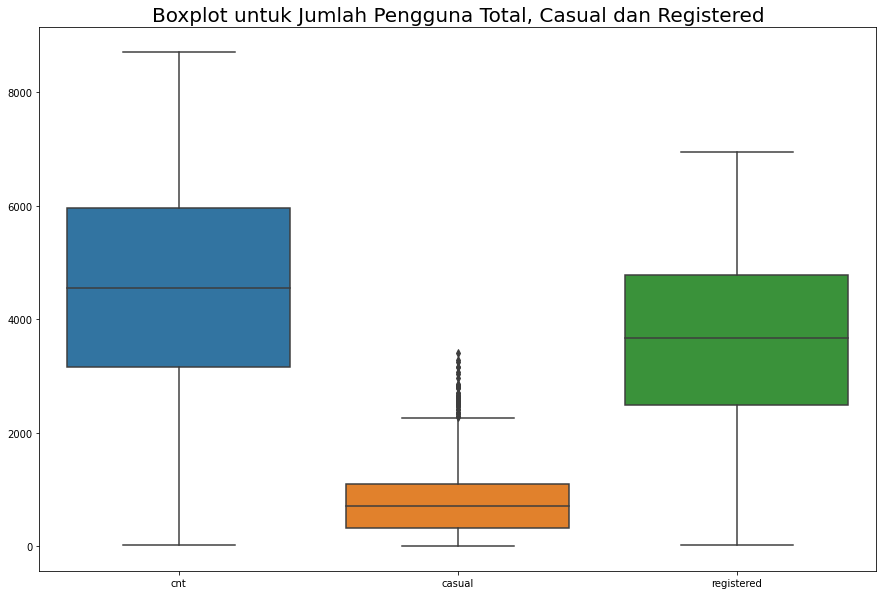

In [ ]:
# Menggunakan boxplot untuk mengecek data outliers dari variabel count, casual dan registered 
fig,ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=rental_sepeda_harian[['cnt',
                          'casual',
                          'registered']],ax=ax)
ax.set_title("Boxplot untuk Jumlah Pengguna Total, Casual dan Registered", fontsize= 20)
fig.show()

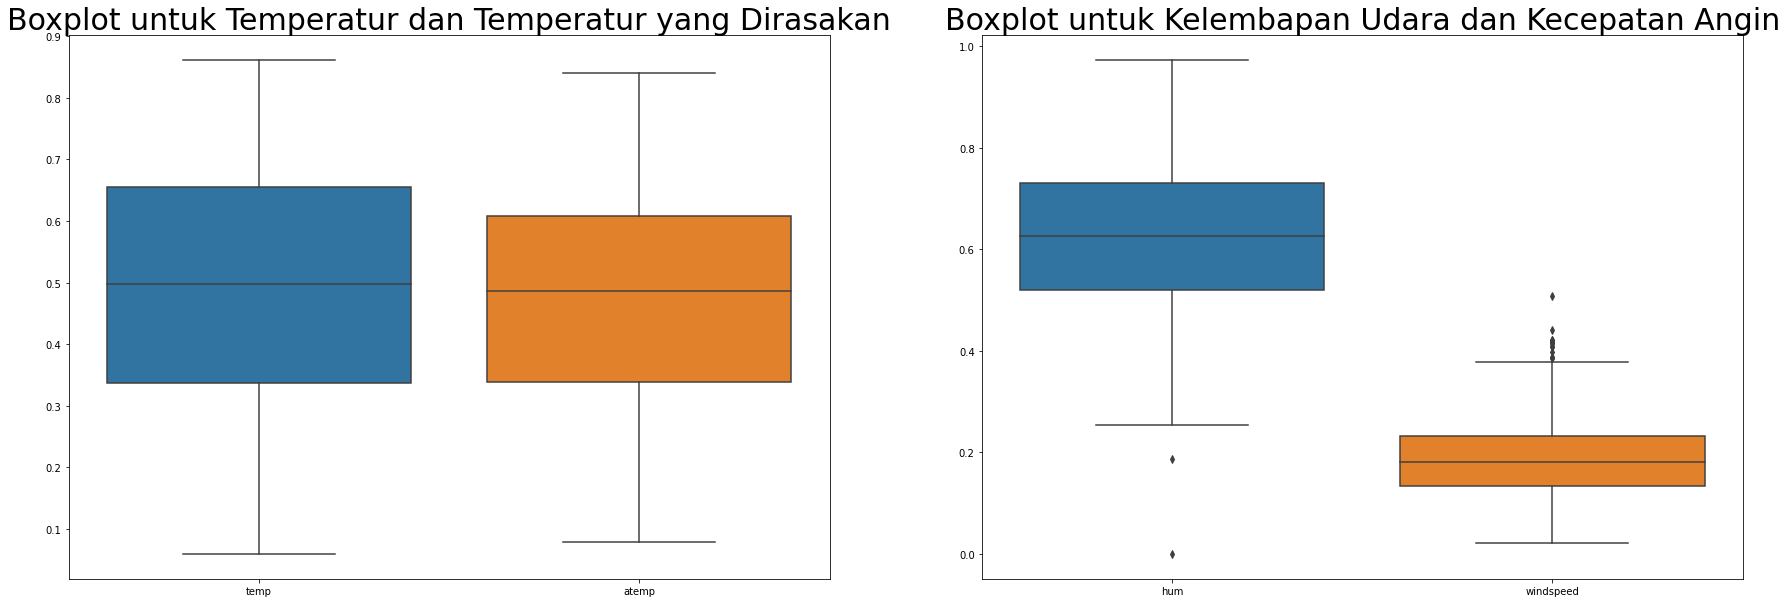

In [ ]:
# Menggunakan boxplot untuk mengecek data outliers dari variabel temp, atemp, hum, and windspeed
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(30,10))
sns.boxplot(data=rental_sepeda_harian[['temp',
                          'atemp']],ax=ax1)
ax1.set_title("Boxplot untuk Temperatur dan Temperatur yang Dirasakan", fontsize= 30)
sns.boxplot(data=rental_sepeda_harian[['hum',
                          'windspeed']],ax=ax2)
ax2.set_title("Boxplot untuk Kelembapan Udara dan Kecepatan Angin", fontsize= 30)
fig.show()

In [ ]:
# Menghitung jumlah data outliers yang ada dari setiap variabel numerik
def find_outlier(data):
    Q1 = np.quantile(data, 0.25)
    Q3 = np.quantile(data, 0.75)

    IQR = Q3 - Q1
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas = Q3 + 1.5 * IQR
    
    outlier = []
    for i in range(len(data)):
        if data[i] > batas_atas:
            outlier.append(data[i])
        if data[i] < batas_bawah:
            outlier.append(data[i])
    return len(outlier)

In [ ]:
# Menunjukkan jumlah outlier dari setiap variabel numerik 
var = ['cnt', 'casual', 'registered', 'temp', 'atemp', 'hum', 'windspeed']

for i in var :
    list_data = rental_sepeda_harian[i].tolist()
    print('Jumlah outlier pada variabel {}:'.format(i),find_outlier(list_data),'\n')

Jumlah outlier pada variabel cnt: 0 

Jumlah outlier pada variabel casual: 44 

Jumlah outlier pada variabel registered: 0 

Jumlah outlier pada variabel temp: 0 

Jumlah outlier pada variabel atemp: 0 

Jumlah outlier pada variabel hum: 2 

Jumlah outlier pada variabel windspeed: 13 



Dari Boxplot di atas kita dapat melihat ada data outliers dalam variabel jumlah pengguna casual (casual), kelembapan udara (hum) dan kecepatan angin (windspeed) yang berjumlah sebanyak 44, 2, dan 13.

### Data Distribution
Memvisualisasikan dan mengamati distribusi variabel numerik dengan menggunakan Histogram.

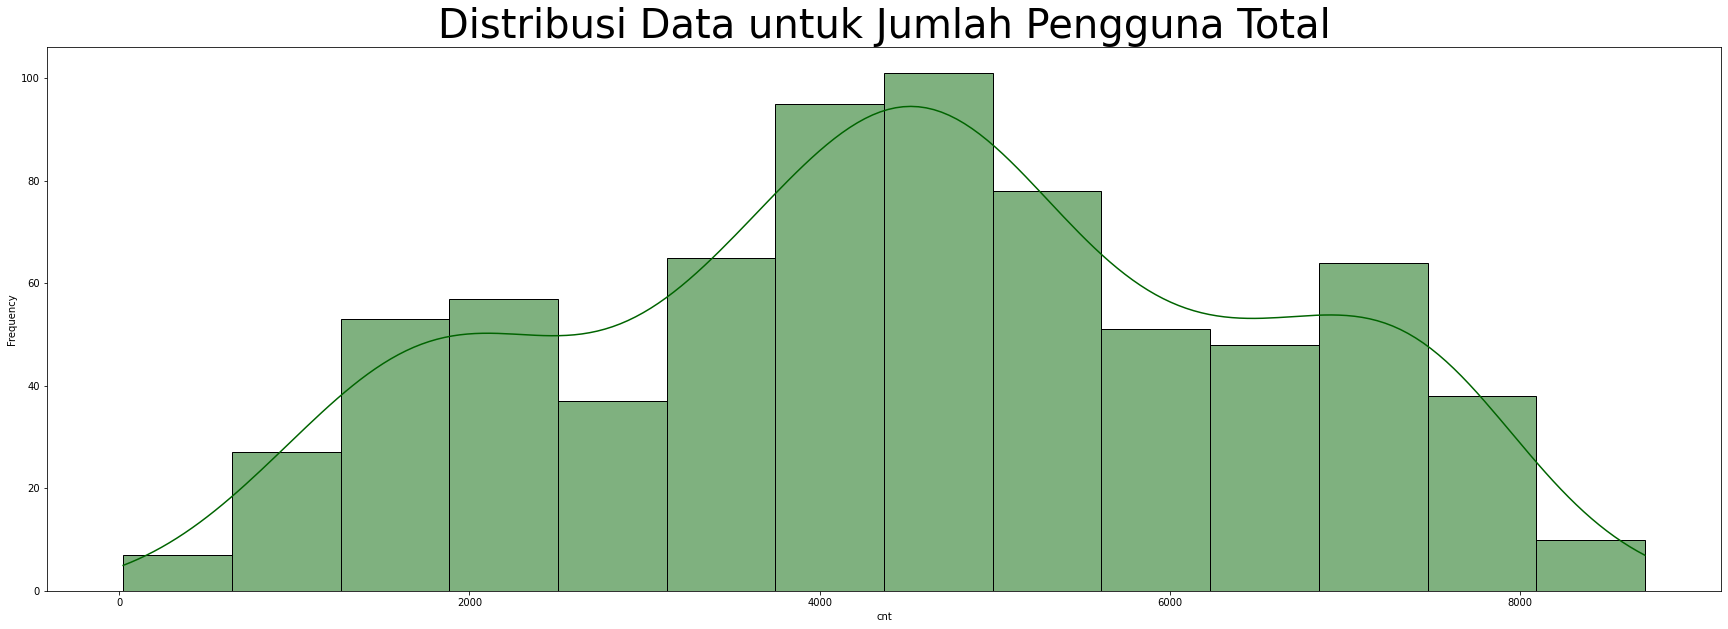

In [ ]:
# Memvisualisasikan distribusi variabel dengan membuat histogram untuk jumlah pengguna total
plt.figure(figsize = (30,10))
sns.histplot(data=rental_sepeda_harian, x="cnt", color="darkgreen", kde=True).set_title("Distribusi Data untuk Jumlah Pengguna Total", fontsize= 40)
plt.xlabel("cnt")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Menggunakan uji Shapiro Wilk untuk menentukkan distribusi data
sw_statistic, sw_pvalue = shapiro(rental_sepeda_harian['cnt'])

if sw_pvalue > 0.05 :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data terdistribusi normal.')
else :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data tidak terdistribusi normal.')

P-Value : 2.080002481363863e-08. Kita berasumsi data tidak terdistribusi normal.


Dapat diamati melalui histogram di atas bahwa data jumlah pengguna total (cnt) tidak terdistribusi normal dikarenakan bentuk histogram yang memiliki 3 puncak.
Hal ini dikonfirmasi melalui uji Shapiro Wilk dimana P-Value lebih kecil dari 0.05 yang menyatakan bahwa data diasumsikan tidak terdistribusi normal.

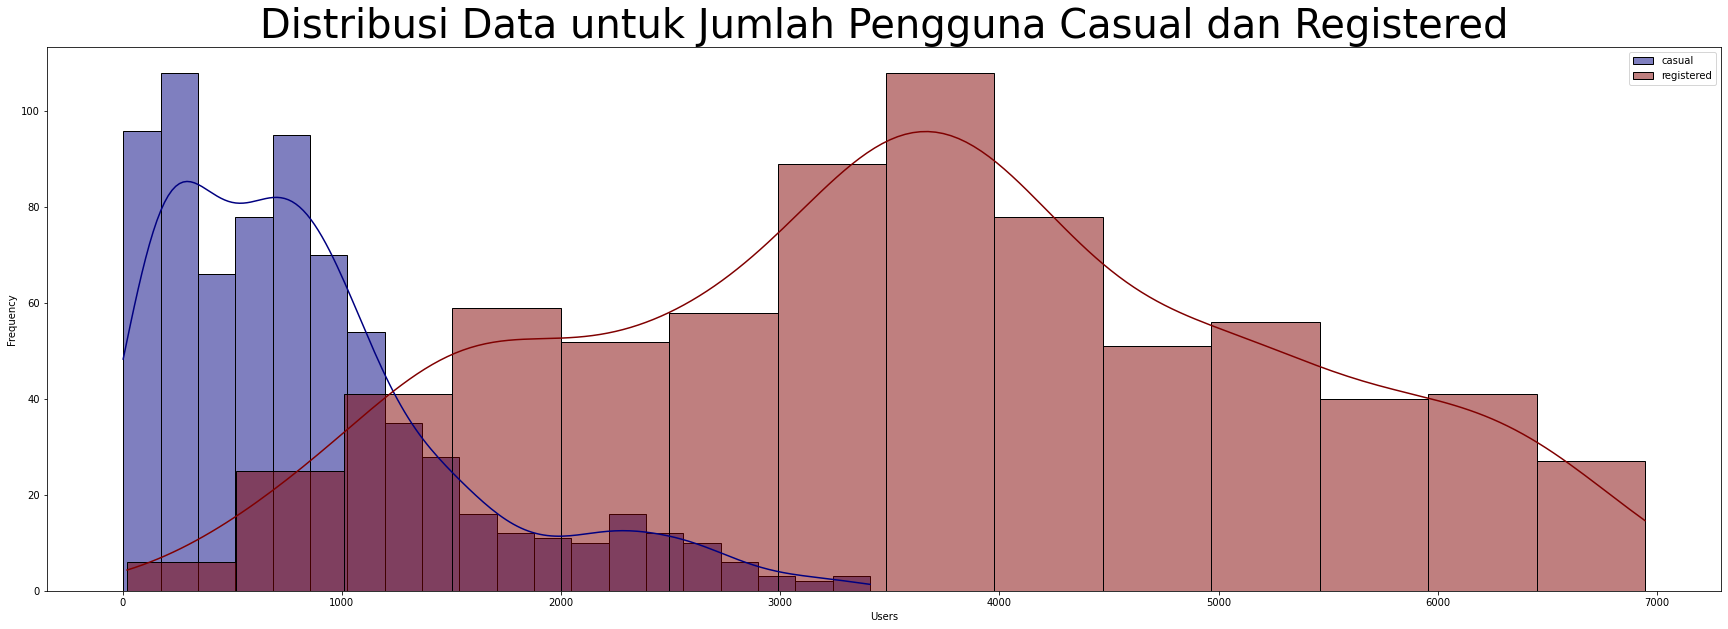

In [ ]:
# Memvisualisasikan distribusi variabel dengan membuat histogram untuk jumlah pengguna casual dan registered
plt.figure(figsize = (30,10))
sns.histplot(data=rental_sepeda_harian, x="casual", color = "navy", label="casual", kde=True)
sns.histplot(data=rental_sepeda_harian, x="registered", color = "maroon", label="registered", kde=True).set_title("Distribusi Data untuk Jumlah Pengguna Casual dan Registered", fontsize= 40)
plt.legend()
plt.xlabel("Users")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Menggunakan uji Shapiro Wilk untuk menentukkan distribusi data
for i in ['casual','registered']:
  sw_statistic, sw_pvalue = shapiro(rental_sepeda_harian[i])
  print('Hasil uji variable {}:'.format(i))
  if sw_pvalue > 0.05 :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data terdistribusi normal.\n')
  else :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data tidak terdistribusi normal.\n')

Hasil uji variable casual:
P-Value : 7.264933727276214e-23. Kita berasumsi data tidak terdistribusi normal.

Hasil uji variable registered:
P-Value : 4.6120135266392026e-07. Kita berasumsi data tidak terdistribusi normal.



Dari histogram dan uji Shapiro Wilk data Registered user dan Casual user tidak terdistribusi normal dan dapat dilihat bahwa data Casual mengalami *positive skewed*, dimana grafik condong ke kanan yang berarti mean akan lebih besar dari median.

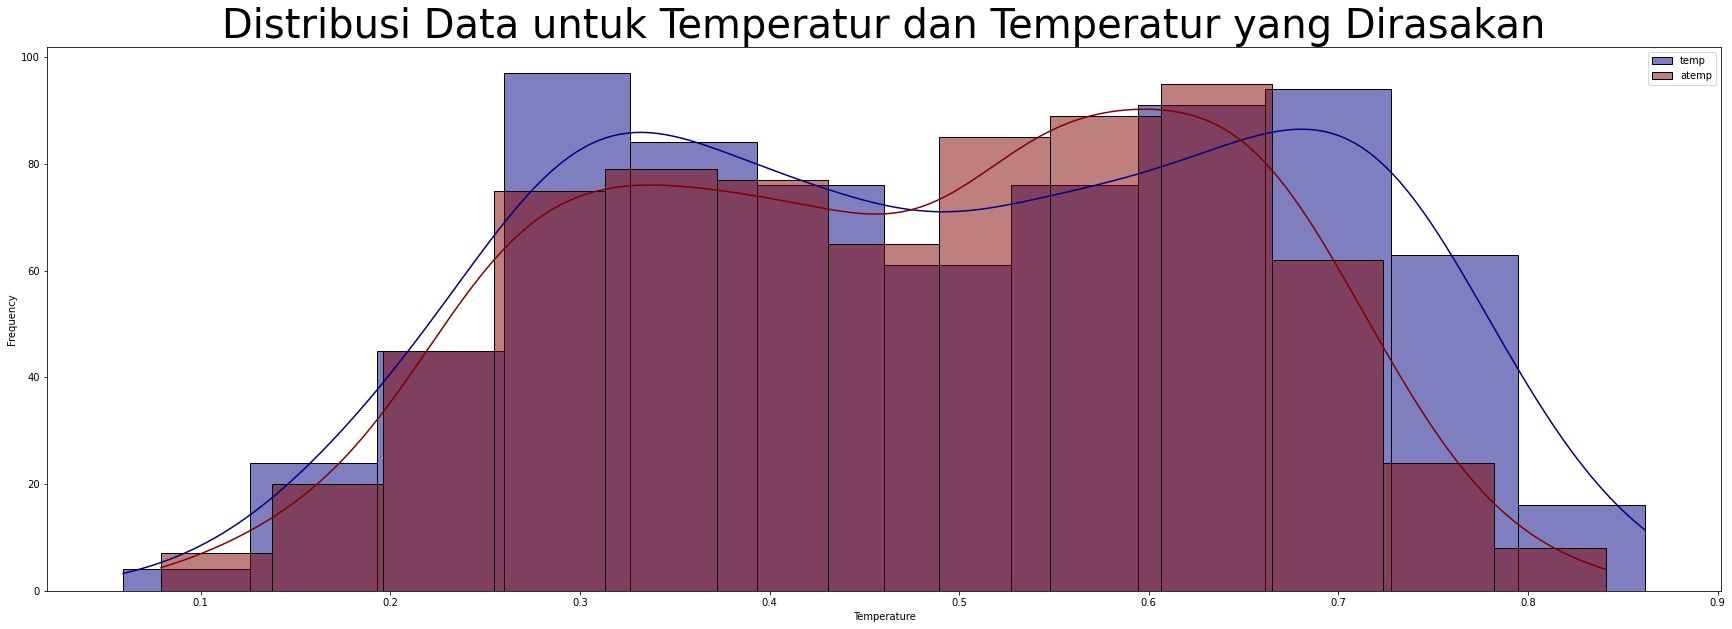

In [ ]:
# Memvisualisasikan distribusi variabel dengan membuat histogram untuk temperatur dan temperatur yang dirasakan
plt.figure(figsize = (30,10))
sns.histplot(data=rental_sepeda_harian, x="temp", color = "navy", label="temp", kde=True)
sns.histplot(data=rental_sepeda_harian, x="atemp", color = "maroon", label="atemp", kde=True).set_title("Distribusi Data untuk Temperatur dan Temperatur yang Dirasakan", fontsize= 40)
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Menggunakan uji Shapiro Wilk untuk menentukkan distribusi data
for i in ['temp','atemp']:
  sw_statistic, sw_pvalue = shapiro(rental_sepeda_perjam[i])
  print('Hasil uji variable {}:'.format(i))
  if sw_pvalue > 0.05 :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data terdistribusi normal.\n')
  else :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data tidak terdistribusi normal.\n')

Hasil uji variable temp:
P-Value : 1.401298464324817e-44. Kita berasumsi data tidak terdistribusi normal.

Hasil uji variable atemp:
P-Value : 3.423372148345528e-42. Kita berasumsi data tidak terdistribusi normal.



Melalui visualisasi dari Histogram di atas, kita dapat mengamati adanya fluktuasi yang terjadi pada kurva yang ada (mempunyai dua puncak) maka dapat disimpulkan untuk data temperatur (temp) dan temperatur yang dirasakan (atemp) tidak terdistribusi normal.

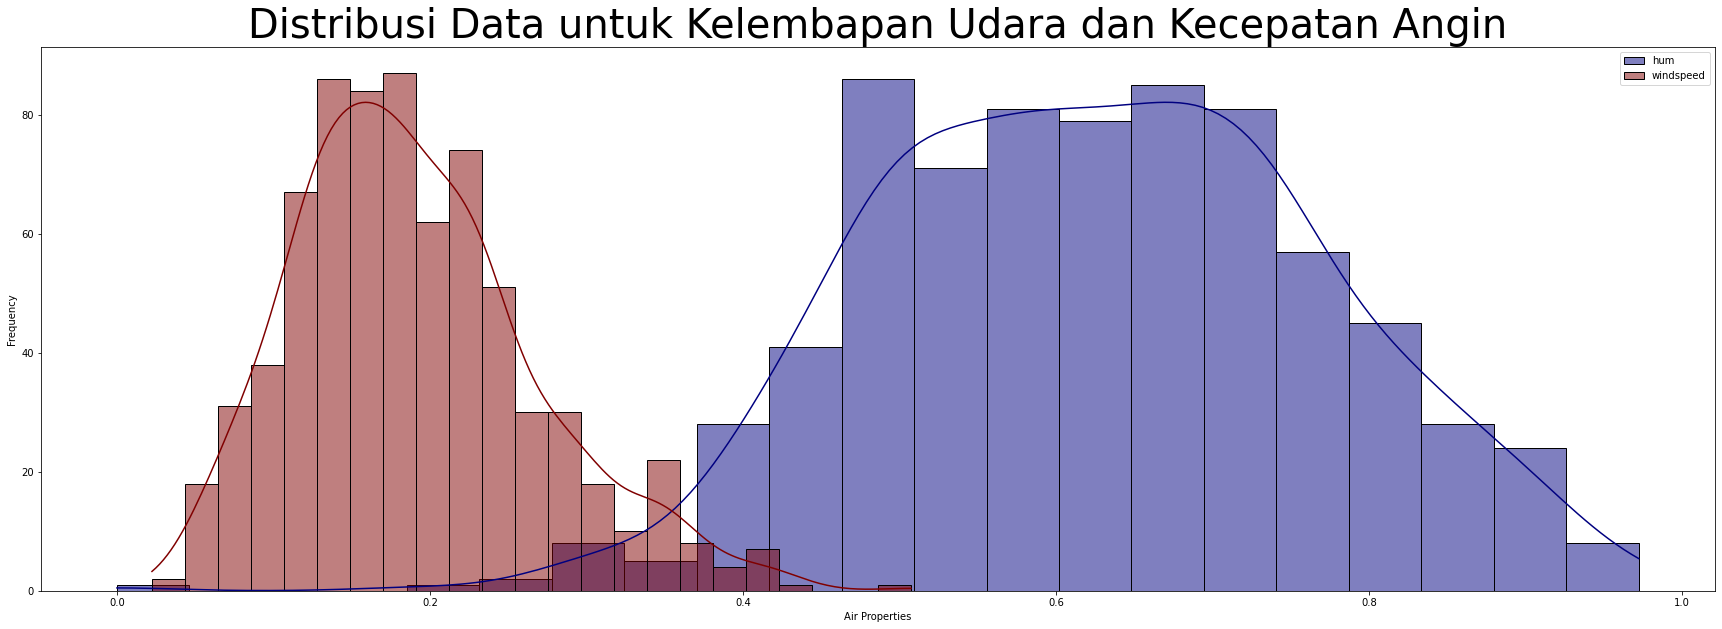

In [ ]:
# Memvisualisasikan distribusi variabel dengan membuat histogram untuk kelembapan udara dan kecepatan angin
plt.figure(figsize = (30,10))
sns.histplot(data=rental_sepeda_harian, x="hum", color = "navy", label="hum", kde=True)
sns.histplot(data=rental_sepeda_harian, x="windspeed", color = "maroon", label="windspeed", kde=True).set_title("Distribusi Data untuk Kelembapan Udara dan Kecepatan Angin", fontsize= 40)
plt.legend()
plt.xlabel("Air Properties")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Menggunakan uji Shapiro Wilk untuk menentukkan distribusi data
for i in ['hum','windspeed']:
  sw_statistic, sw_pvalue = shapiro(rental_sepeda_harian[i])
  print('Hasil uji variable {}:'.format(i))
  if sw_pvalue > 0.05 :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data terdistribusi normal.\n')
  else :
    print(f'P-Value : {sw_pvalue}. Kita berasumsi data tidak terdistribusi normal.\n')

Hasil uji variable hum:
P-Value : 0.0024830217007547617. Kita berasumsi data tidak terdistribusi normal.

Hasil uji variable windspeed:
P-Value : 8.4240031617e-11. Kita berasumsi data tidak terdistribusi normal.



Bisa disimpulkan dari Histogram dan uji Shapiro Wilk bahwa data kelembapan udara (hum) dan kecepatan angin (windspeed) tidak terdistribusi normal karena keduanya memiliki nilai p-value yang lebih kecil dari 0.05.

### Data Cardinalities
Mengecek apakah ada kardinalitas yang tinggi dari variabel kategorik di dalam dataset yang tersedia. Kardinalitas: jumlah dari kategori unik di dalam suatu variabel kategorik. 

Apabila ada kardinalitas tinggi yang terdeteksi dalam suatu feature maka data harus ditangani dalam tahap Preprocessing.

In [ ]:
# Mengecek jumlah kategori yang unik dari setiap variabel kategorikriables
cat_var = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for i in cat_var :
    print('Variabel {} memiliki data unik sebanyak {} :'.format(i, rental_sepeda_harian[i].nunique()),rental_sepeda_harian[i].unique(),'\n')

Variabel season memiliki data unik sebanyak 4 : [1 2 3 4] 

Variabel yr memiliki data unik sebanyak 2 : [0 1] 

Variabel mnth memiliki data unik sebanyak 12 : [ 1  2  3  4  5  6  7  8  9 10 11 12] 

Variabel holiday memiliki data unik sebanyak 2 : [0 1] 

Variabel weekday memiliki data unik sebanyak 7 : [6 0 1 2 3 4 5] 

Variabel workingday memiliki data unik sebanyak 2 : [0 1] 

Variabel weathersit memiliki data unik sebanyak 3 : [2 1 3] 



Dapat disimpulkan bahwa tidak ada variabel kategorik yang memiliki kardinalitas yang tinggi, maka proes untuk menangani data dengan kardinalitas tinggi tidak diperlukan dalam tahan Preprocessing.

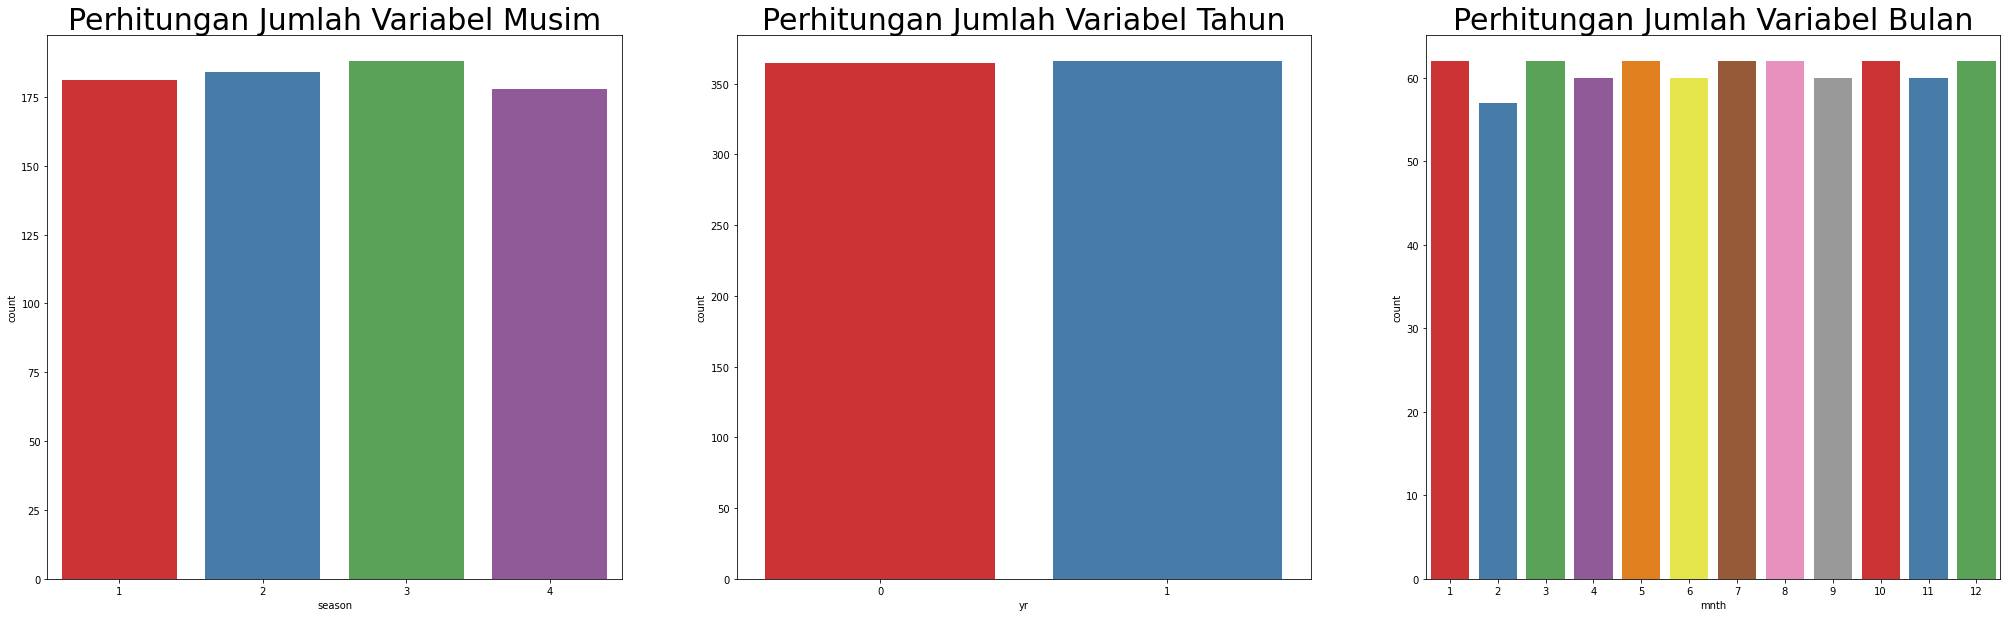

In [ ]:
# Memvisualisasi frekuensi dari kategori unik di setiap variabel kategorik 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(35,10))
sns.countplot(data=rental_sepeda_harian, x='season', ax=ax[0], palette="Set1").set_title("Perhitungan Jumlah Variabel Musim", fontsize= 30)
sns.countplot(data=rental_sepeda_harian, x='yr', ax=ax[1], palette="Set1").set_title("Perhitungan Jumlah Variabel Tahun", fontsize= 30)
sns.countplot(data=rental_sepeda_harian, x='mnth', ax=ax[2], palette="Set1").set_title("Perhitungan Jumlah Variabel Bulan", fontsize= 30)
fig.show()

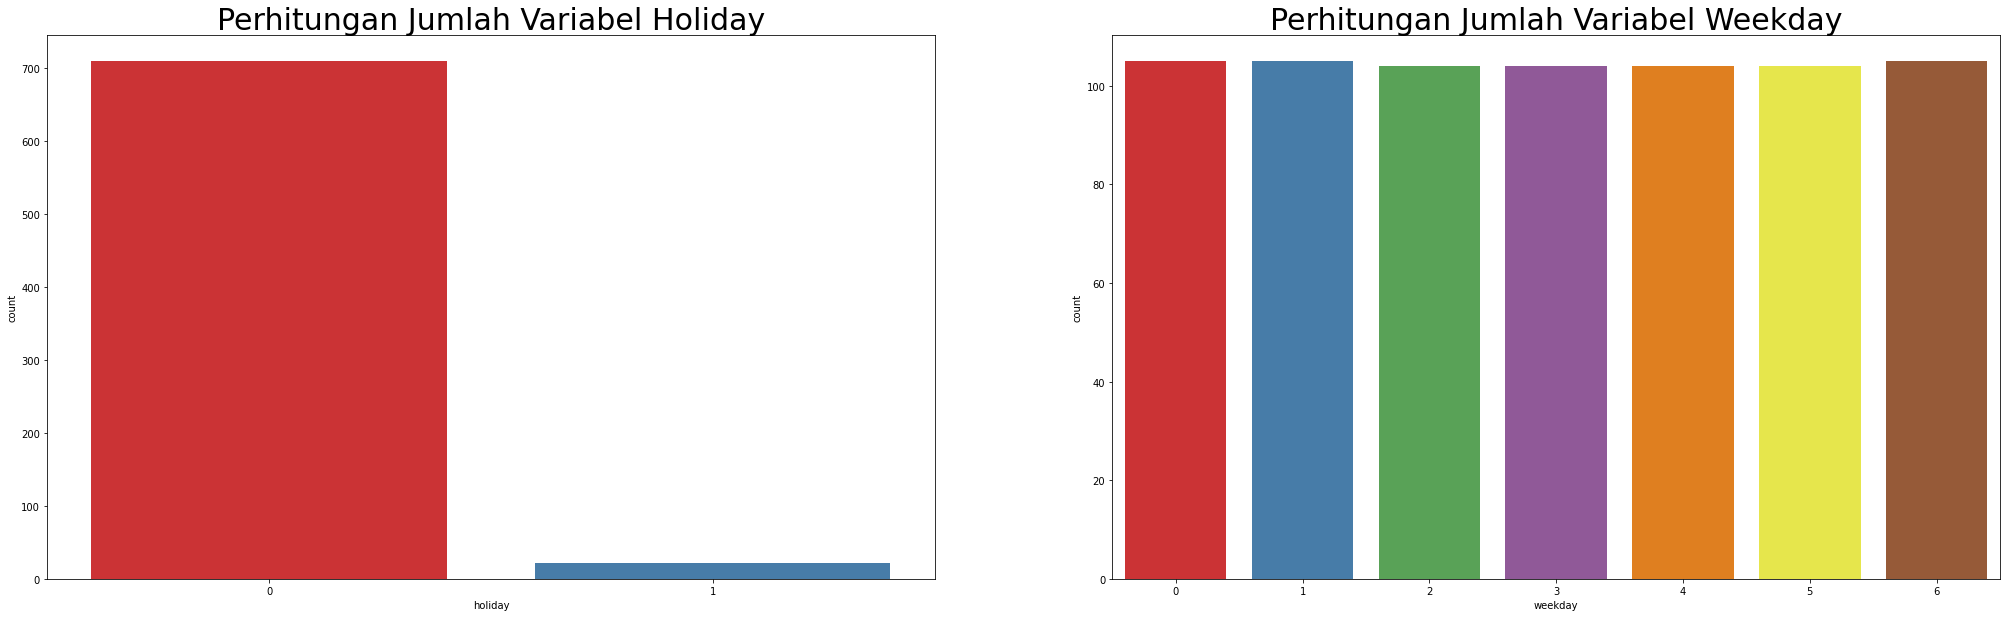

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(35,10))
sns.countplot(data=rental_sepeda_harian, x='holiday', ax=ax[0],  palette="Set1").set_title("Perhitungan Jumlah Variabel Holiday", fontsize= 30)
sns.countplot(data=rental_sepeda_harian, x='weekday', ax=ax[1],  palette="Set1").set_title("Perhitungan Jumlah Variabel Weekday", fontsize= 30)
fig.show()

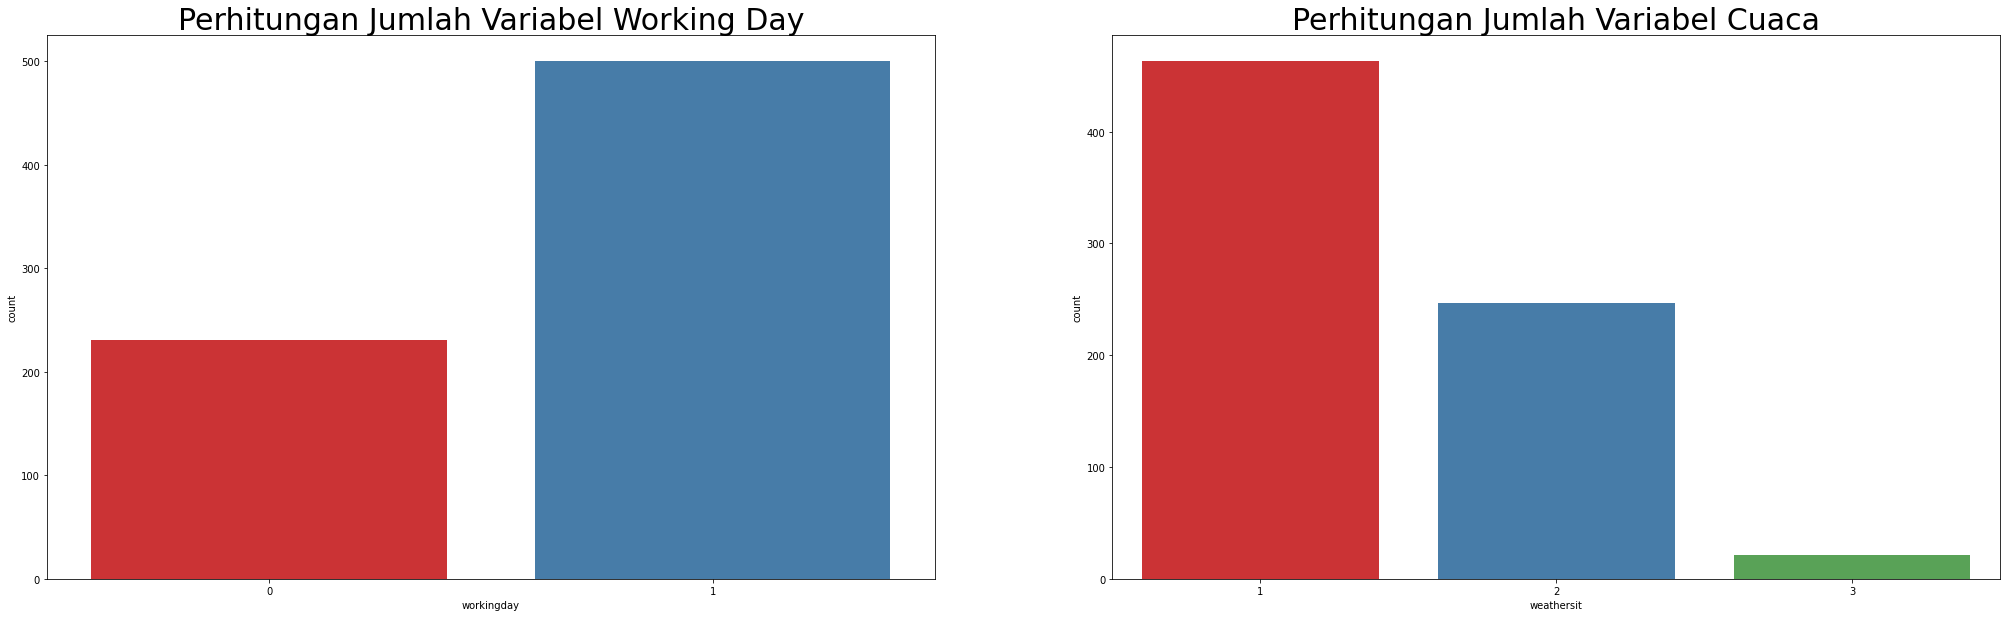

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(35,10))
sns.countplot(data=rental_sepeda_harian, x='workingday', ax=ax[0],  palette="Set1").set_title("Perhitungan Jumlah Variabel Working Day", fontsize= 30)
sns.countplot(data=rental_sepeda_harian, x='weathersit', ax=ax[1],  palette="Set1").set_title("Perhitungan Jumlah Variabel Cuaca", fontsize= 30)
fig.show()

Melalui countplot di atas kita dapat melihat visualisasi dari jumlah data setiap variabel kategorik yang ada pada dataset.

### Data Correlation
Memvisualisasikan dan mengamati korelasi antara variabel dalam dataset menggunakan *Scatter Plot* and *Heatmap*.

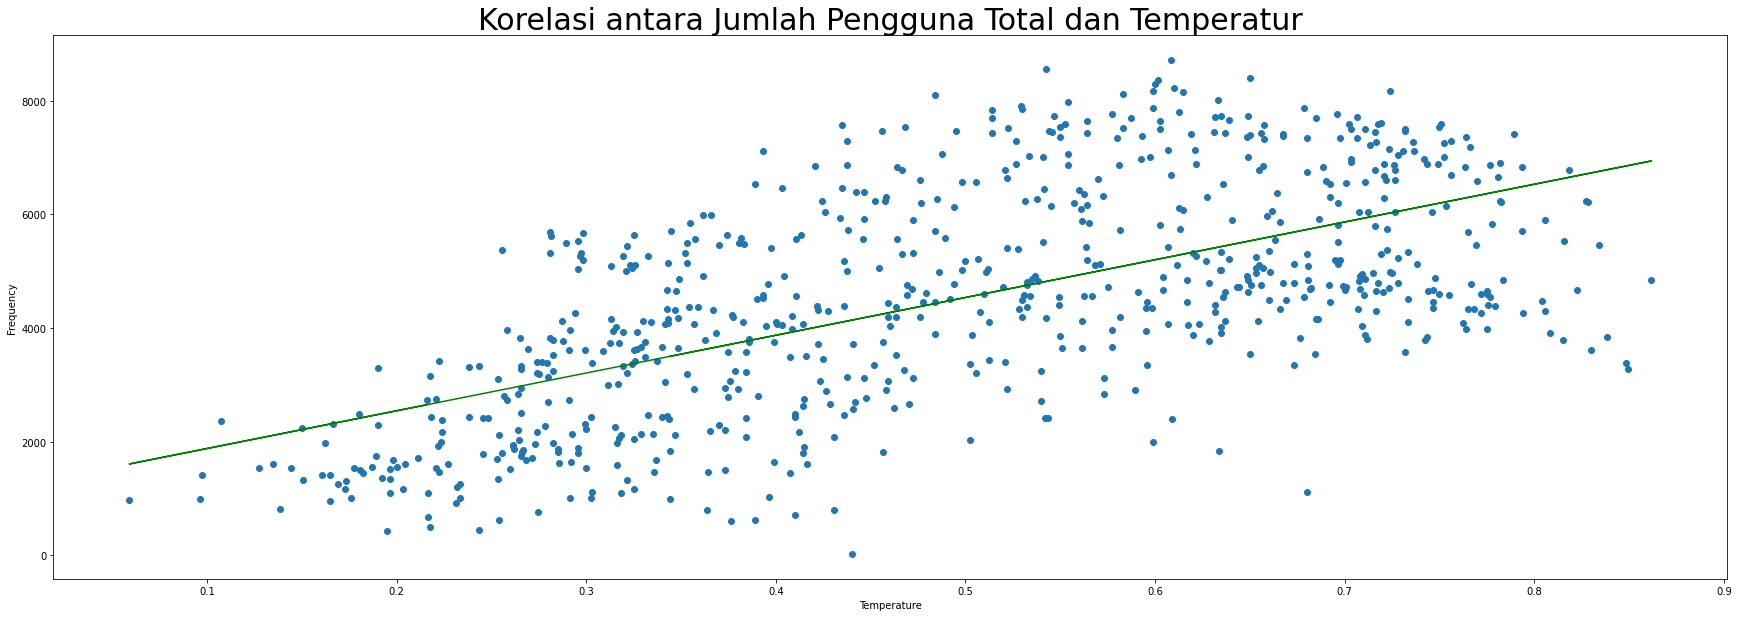

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel cnt vs temp
plt.figure(figsize = (30,10))
plt.scatter(rental_sepeda_harian['temp'], rental_sepeda_harian['cnt'])
plt.title('Korelasi antara Jumlah Pengguna Total dan Temperatur', fontdict = {'fontsize' : 30})
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# menambah garis regresi pada scatter plot
x = rental_sepeda_harian['temp']
y = rental_sepeda_harian['cnt']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='green')
plt.show()

Dari scatter plot di atas kita dapat melihat korelasi/hubungan antara jumlah total pengguna dengan temperatur. Dapat kita amati melalui garis regresi yang ada bahwa semakin bertambahnya temperatur maka jumlah penyewaan sepeda akan bertambah juga. 

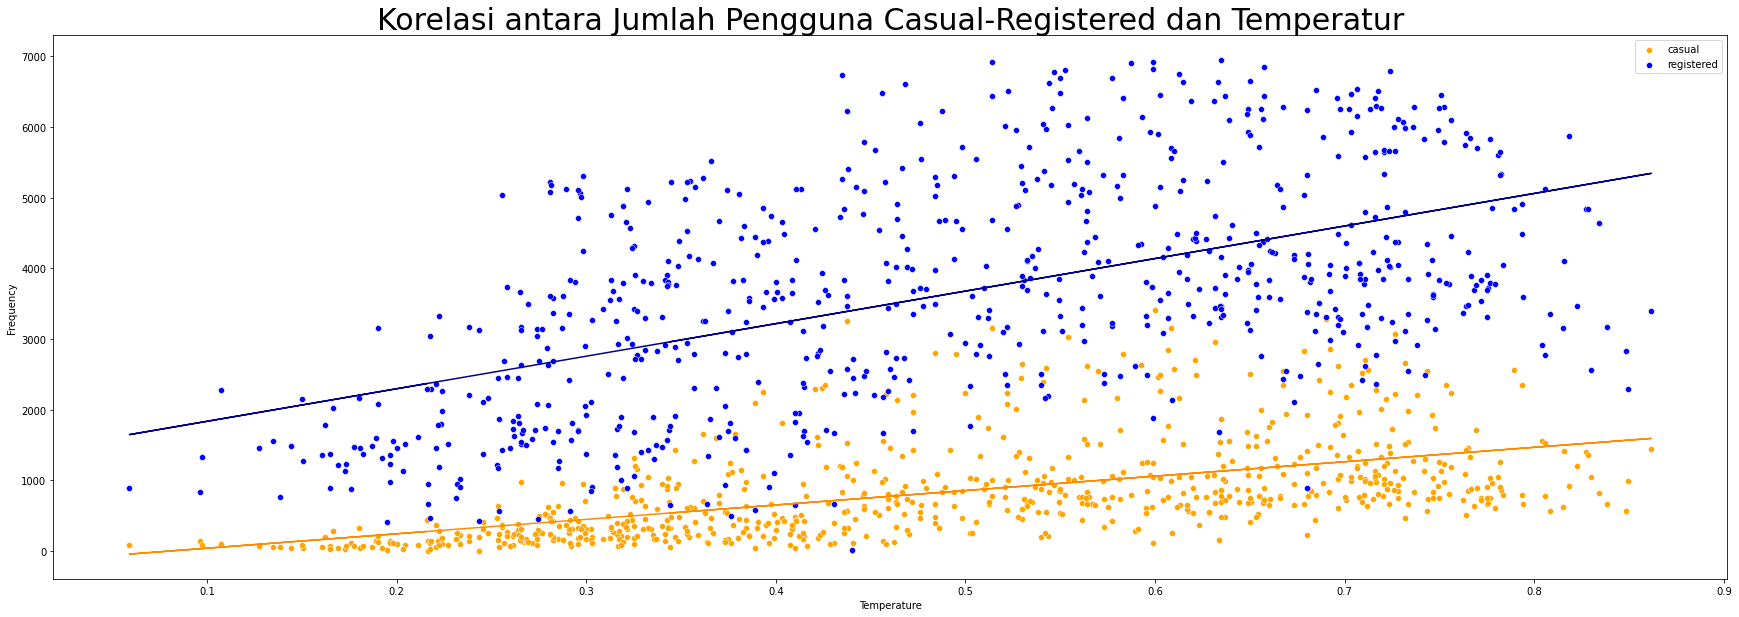

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel casual & registered vs temp
plt.figure(figsize = (30,10))
sns.scatterplot(data=rental_sepeda_harian, x='temp', y='casual', color = 'orange', label='casual')
sns.scatterplot(data=rental_sepeda_harian, x='temp', y='registered', color = 'blue', label='registered')
plt.legend()
plt.title('Korelasi antara Jumlah Pengguna Casual-Registered dan Temperatur', fontdict = {'fontsize' : 30})
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# menambah garis regresi pada scatter plot
x = rental_sepeda_harian['temp']
y1 = rental_sepeda_harian['casual']
y2 = rental_sepeda_harian['registered']
m1, b1 = np.polyfit(x, y1, 1)
plt.plot(x, m1*x+b1, color='darkorange')
m2, b2 = np.polyfit(x, y2, 1)
plt.plot(x, m2*x+b2, color='darkblue')
plt.show()

Dari scatter plot di atas kita dapat melihat korelasi/hubungan antara jumlah total pengguna casual dan registered dengan temperatur. Dapat kita amati melalui garis regresi yang ada bahwa semakin bertambahnya temperatur maka jumlah penyewaan sepeda baik casual dan registered akan bertambah juga. Dimana penambahan pengguna registered lebih tinggi ditunjukkan oleh kemiringan garis regresinya.

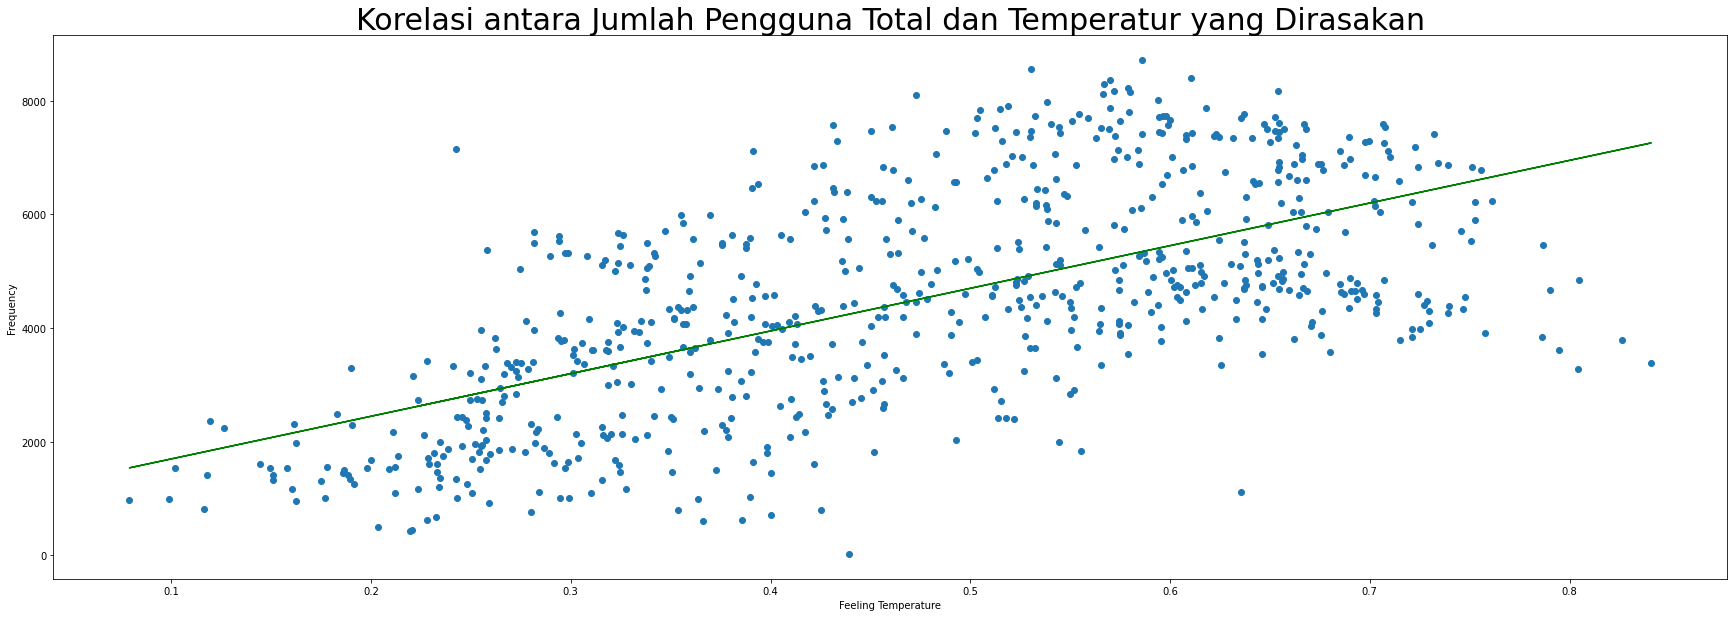

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel cnt vs atemp
plt.figure(figsize = (30,10))
plt.scatter(rental_sepeda_harian['atemp'], rental_sepeda_harian['cnt'])
plt.title('Korelasi antara Jumlah Pengguna Total dan Temperatur yang Dirasakan', fontdict = {'fontsize' : 30})
plt.xlabel('Feeling Temperature')
plt.ylabel('Frequency')

# Menambah garis regresi pada scatter plot
x = rental_sepeda_harian['atemp']
y = rental_sepeda_harian['cnt']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='green')
plt.show()

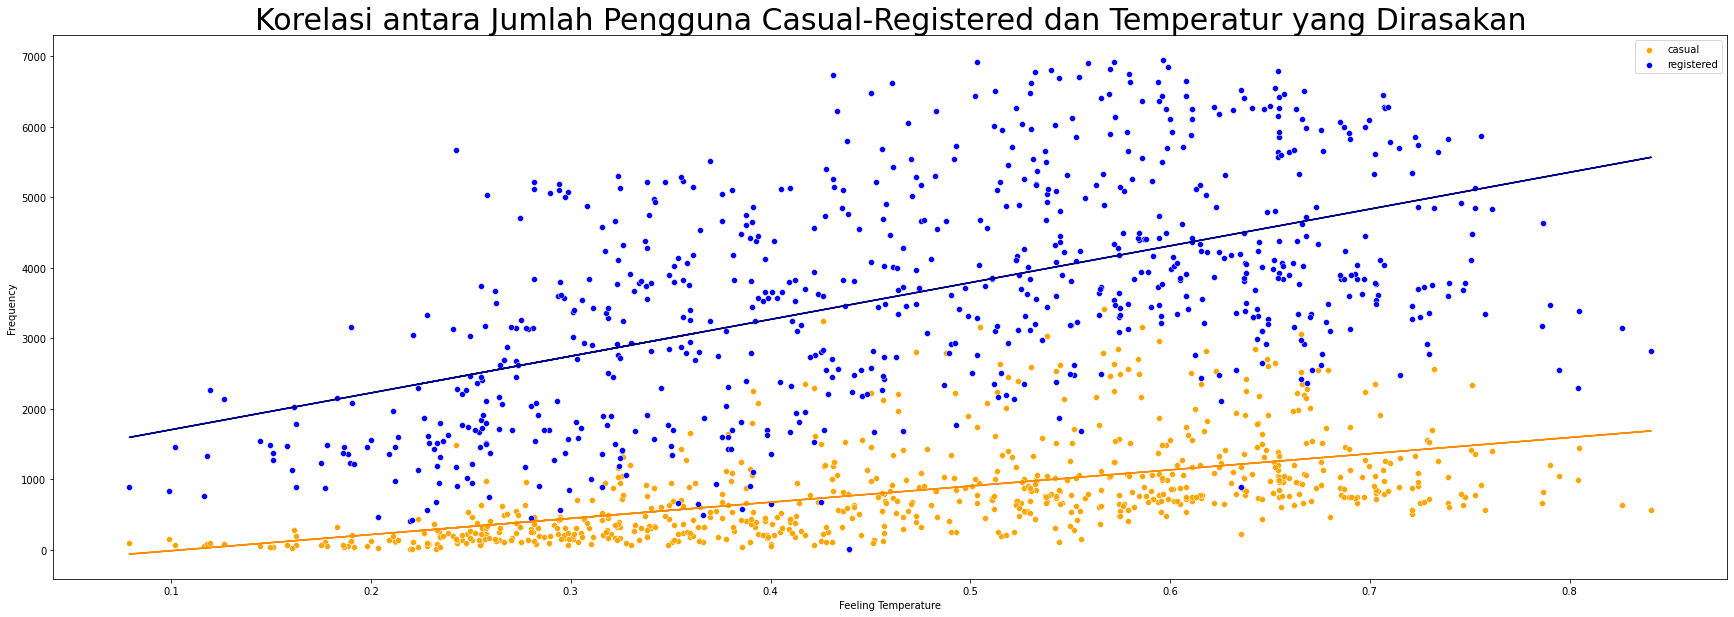

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel casual & registered vs atemp
plt.figure(figsize = (30,10))
sns.scatterplot(data=rental_sepeda_harian, x='atemp', y='casual', color = 'orange', label='casual')
sns.scatterplot(data=rental_sepeda_harian, x='atemp', y='registered', color = 'blue', label='registered')
plt.legend()
plt.title('Korelasi antara Jumlah Pengguna Casual-Registered dan Temperatur yang Dirasakan', fontdict = {'fontsize' : 30})
plt.xlabel('Feeling Temperature')
plt.ylabel('Frequency')

# Menambah garis regresi pada scatter plot
x = rental_sepeda_harian['atemp']
y1 = rental_sepeda_harian['casual']
y2 = rental_sepeda_harian['registered']
m1, b1 = np.polyfit(x, y1, 1)
plt.plot(x, m1*x+b1, color='darkorange')
m2, b2 = np.polyfit(x, y2, 1)
plt.plot(x, m2*x+b2, color='darkblue')
plt.show()

Dari kedua scatter plot di atas antara jumlah pengguna dan temperatur yang dirasakan (atemp), kita dapat mengamati bahwa korelasi antara jumlah total pengguna dan juga temperatur yang dirasakan memiliki distribusi yang mirip dengan scatter plot sebelumnya. Maka kita memutuskan untuk menggunakan salah satu variabel saja untuk model machine learning yaitu termperatur (temp).

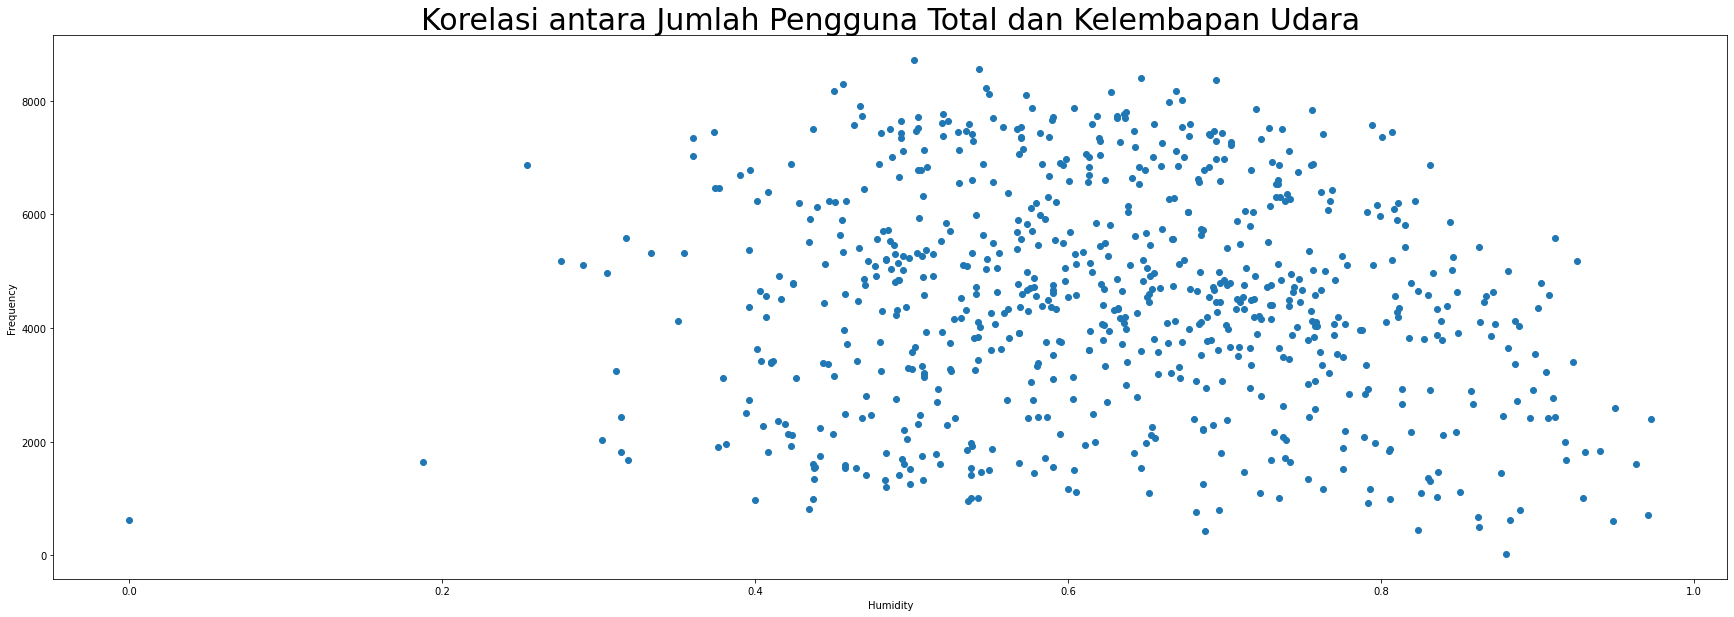

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel cnt vs hum
plt.figure(figsize = (30,10))
plt.scatter(rental_sepeda_harian['hum'], rental_sepeda_harian['cnt'])
plt.title('Korelasi antara Jumlah Pengguna Total dan Kelembapan Udara', fontdict = {'fontsize' : 30})
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.show()

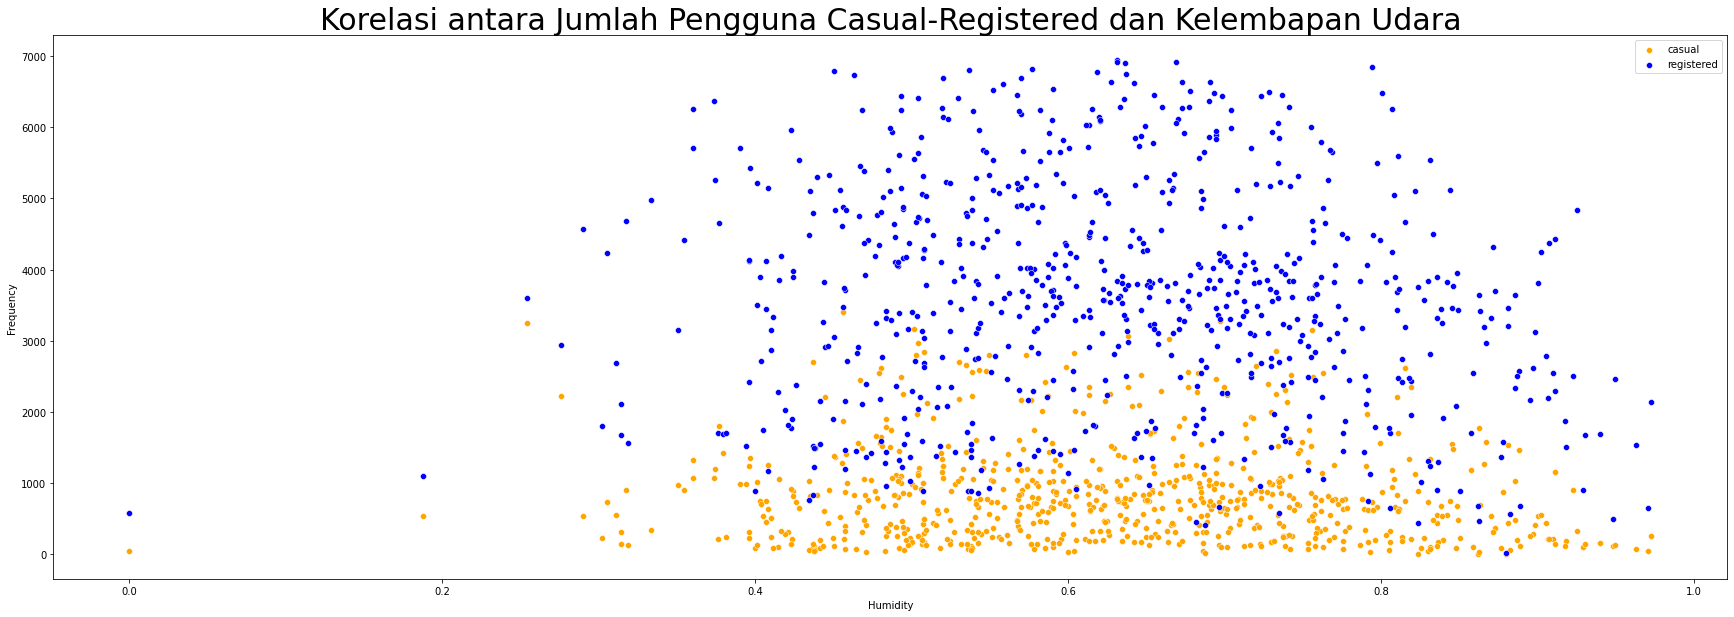

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel casual & registered vs hum
plt.figure(figsize = (30,10))
sns.scatterplot(data=rental_sepeda_harian, x='hum', y='casual', color = 'orange', label='casual')
sns.scatterplot(data=rental_sepeda_harian, x='hum', y='registered', color = 'blue', label='registered')
plt.legend()
plt.title('Korelasi antara Jumlah Pengguna Casual-Registered dan Kelembapan Udara', fontdict = {'fontsize' : 30})
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.show()

Dari scatter plot di atas kita dapat menyimpulkan bahwa tidak ada korelasi antara jumlah total pengguna (casual maupun registered) dan kelembapan udara. Ditunjukan oleh banyaknya data yang berkumpul di antara range 0.4-0.8 dan data tersebar secara random.

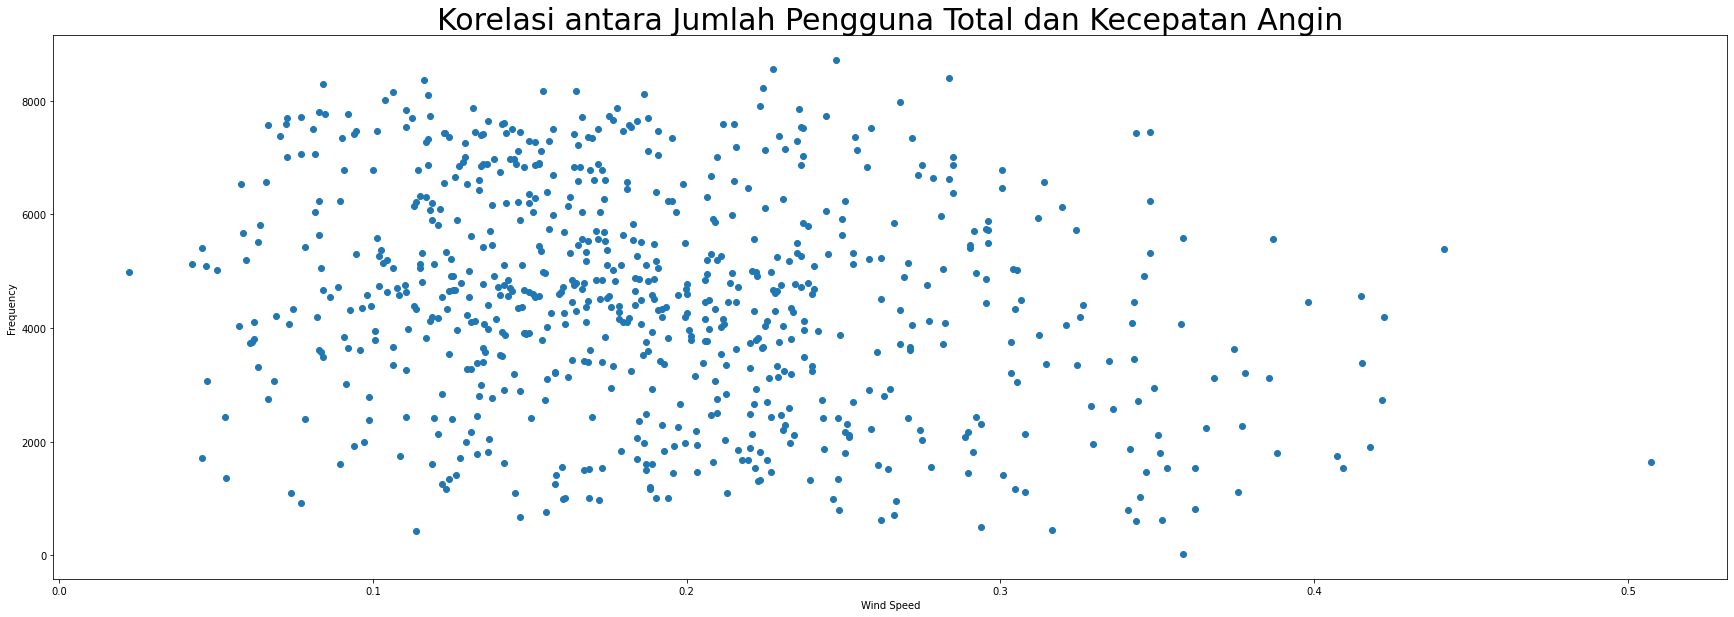

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel cnt vs windspeed
plt.figure(figsize = (30,10))
plt.scatter(rental_sepeda_harian['windspeed'], rental_sepeda_harian['cnt'])
plt.title('Korelasi antara Jumlah Pengguna Total dan Kecepatan Angin', fontdict = {'fontsize' : 30})
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

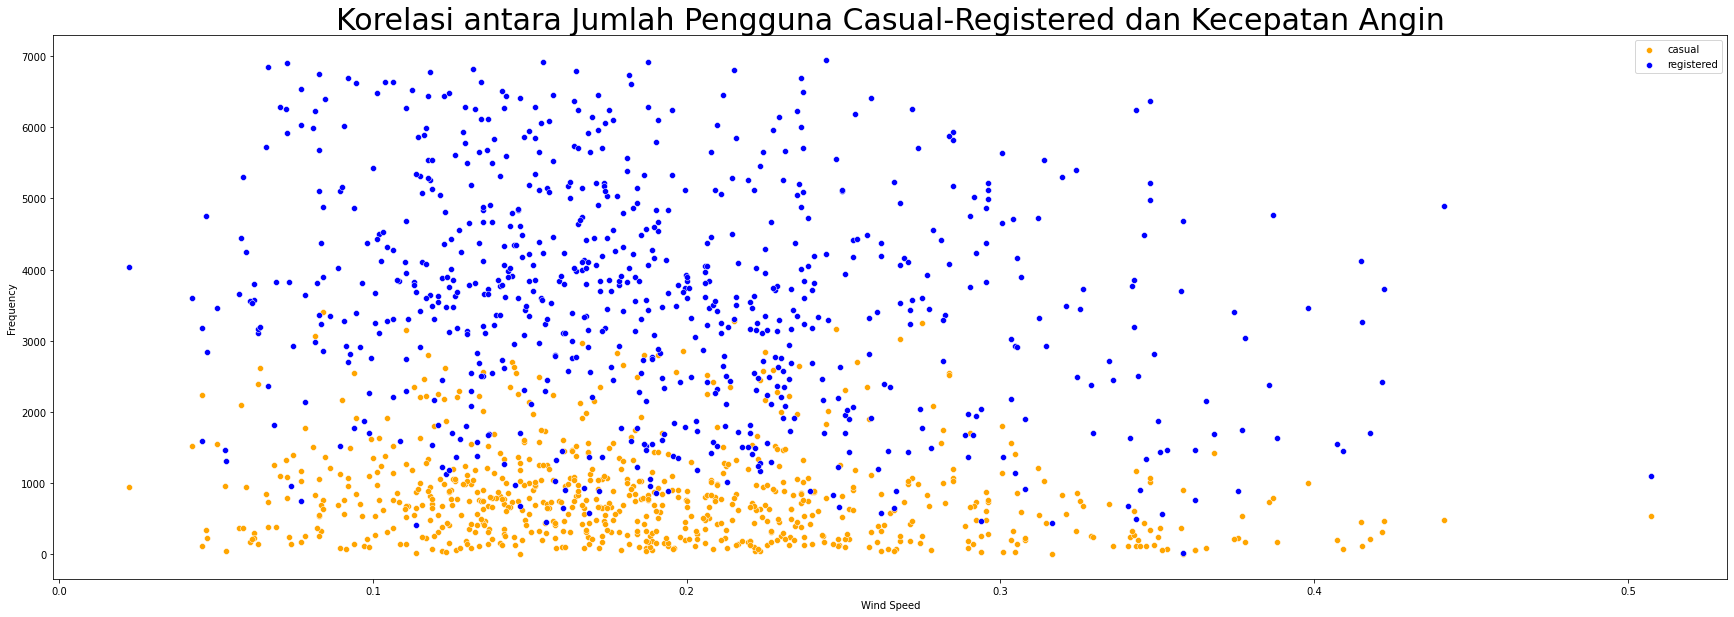

In [ ]:
# Memvisualisasi korelasi data antara variabel kuantitatif dan jumlah pengguna total menggunakan scatter plot
# untuk variabel casual & registered vs windspeed
plt.figure(figsize = (30,10))
sns.scatterplot(data=rental_sepeda_harian, x='windspeed', y='casual', color = 'orange', label='casual')
sns.scatterplot(data=rental_sepeda_harian, x='windspeed', y='registered', color = 'blue', label='registered')
plt.legend()
plt.title('Korelasi antara Jumlah Pengguna Casual-Registered dan Kecepatan Angin', fontdict = {'fontsize' : 30})
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

Sama halnya dengan scatter plot ketiga, data dari scatter plot ini juga tersebar secara random sehingga kita dapat menarik kesimpulan bahwa tidak adanya korelasi antara jumlah total pengguna (casual maupun registered) dan kecepatan angin.

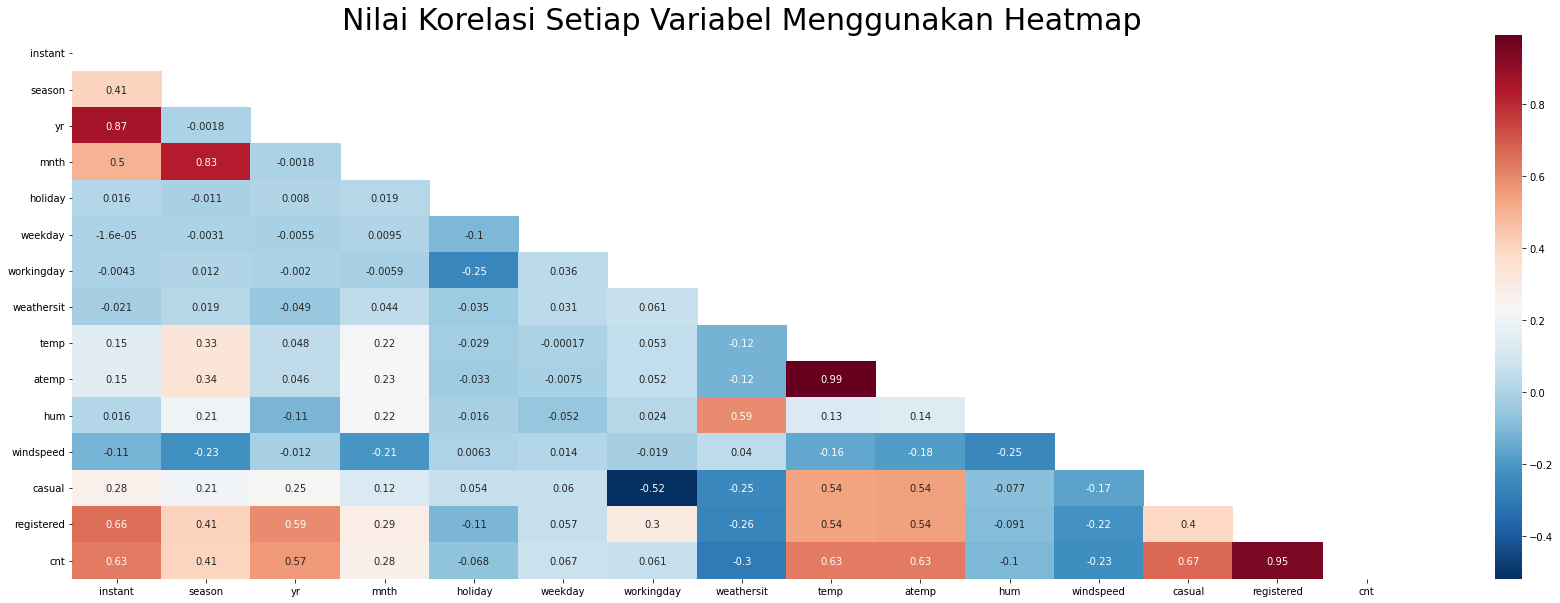

In [ ]:
# Memvisualisasi korelasi antara semua variabel menggunakan heatmap
plt.figure(figsize=(30,10))
mask = np.zeros_like(rental_sepeda_harian.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(rental_sepeda_harian.corr(),cmap='RdBu_r',mask=mask, annot=True)
plt.title('Nilai Korelasi Setiap Variabel Menggunakan Heatmap', fontdict = {'fontsize' : 30})
plt.show()

Nilai yang kita dapatkan dari heatmap ini menunjukkan nilai korelasi antara variabel. Nilai ini dapat berupa korelasi positif dan juga negatif. Semakin mendekati 1 maka korelasi positif semakin kuat dan semakin mendekati -1 maka korelasi negatif semakin kuat.

Dari heatmap di atas kita dapat menyimpulkan bahwa ada beberapa korelasi antara variabel yang ada, seperti:
- Kedua variabel temperatur (temp dan atemp) memiliki korelasi positif yang sangat kuat dengan satu sama lain dengan nilai 0.99.
- Jumlah pengguna casual yang tidak berlangganan memiliki korelasi negatif yang cukup kuat dengan hari kerja (workingday) senilai -0.52.
- Korelasi jumlah pengguna total (cnt) dan juga kedua variabel temperatur (temp dan atemp) memiliki korelasi positif di nilai 0.63.
- Jumlah pengguna yang berlangganan (registered) memiliki korelasi positif yang sangat kuat dengan jumlah pengguna total (cnt) dengan nilai sebesar 0.95.  
- Terdapat korelasi positif yang sangat kuat antara musim (season) dan bulan (mnth) ditunjukan oleh nilai sebesar 0.83.
- Terdapat korelasi positif yang cukup kuat antara kelembapan udara (humidity) dan keadaan cuaca (weathersit) ditunjukkan oleh nilai 0.59.

### Business Insight
Mendapatkan business insight dari dataset yang ada menggunakan visualisasi data dengan cara mengamati pergerakan demand dari data 2011-2012 untuk dapat mempersiapkan business plan pada tahun yang akan datang.  

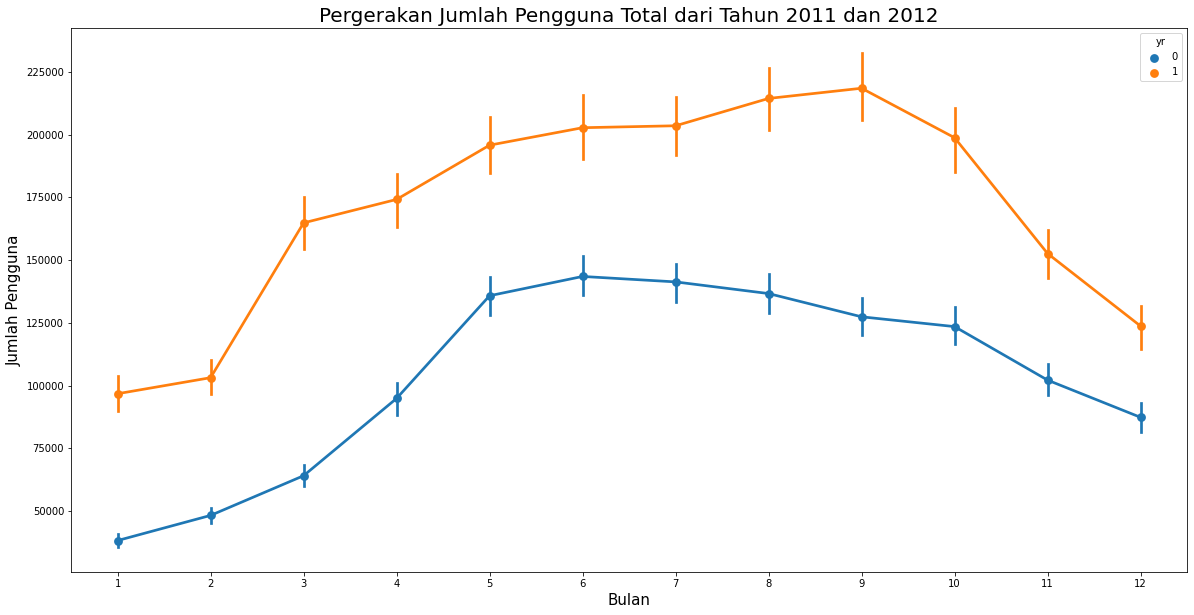

In [ ]:
# Mendapatkan business insight dengan memvisualisasikan pergerakan jumlah pengguna di tahun 2011 dan 2012
plt.figure(figsize=(20,10))
sns.pointplot(data=rental_sepeda_perjam[['mnth',
                           'cnt',
                           'yr']],
              x='mnth',
              y='cnt',
              hue='yr',
              estimator = np.sum
              )
plt.title('Pergerakan Jumlah Pengguna Total dari Tahun 2011 dan 2012', size = 20)
plt.xlabel('Bulan', size = 15)
plt.ylabel('Jumlah Pengguna', size = 15)
plt.show()

**Dari plot di atas kita dapat mendapatkan sebuah business insight bahwa demand akan meningkat di tahun berikutnya seperti yang dapat kita amati bahwa jumlah pengguna total meningkat di tahun 2012 (yr: 1). Dapat kita amati juga kalau demand akan sangat sedikit ketika memasuki bulan Januari dan akan sangat tinggi di bulan Oktober.**

Hal ini merupakan business insight inti dan kita tampilkan di bagian EDA. Untuk business insight lain akan dibahas lebih lagi di bagian Analisis.

## Data Cleaning & Preprocessing
Proses pembersihan dan penyiapan data agar lebih siap untuk digunakan pada tahapan selanjutnya yaitu Analisis data.

### Fixing Dataset
Memperbaiki dataset dengan cara menghapus kolom yang tidak dibutuhkan, mengubah nama setiap kolom dan mengubah tipe data dengan yang sesuai.

In [ ]:
# Menghapus kolom yang tidak diperlukan karena mengandung informasi yang tidak dibutuhkan
df_hour = rental_sepeda_perjam.drop(columns=['instant','atemp'], axis=1)

# Mengganti nama kolom agar lebih mudah dimengerti
df_hour.rename(columns={'dteday':'date',
                     'yr':'year',
                     'mnth':'month',
                     'hr':'hour',
                     'temp':'temperature',
                     'hum':'humidity',
                     'cnt':'total_count'},inplace=True)

# Menampilkan kolom terbaru setelah diubah
df_hour.head()

,date,season,year,month,hour,holiday,weekday,workingday,weathersit,temperature,humidity,windspeed,casual,registered,total_count
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1


In [ ]:
# Menghapus kolom yang tidak diperlukan karena mengandung informasi yang tidak dibutuhkan
df_day = rental_sepeda_harian.drop(columns=['instant','atemp'], axis=1)

# Mengganti nama kolom agar lebih mudah dimengerti
df_day.rename(columns={'dteday':'date',
                     'yr':'year',
                     'mnth':'month',
                     'temp':'temperature',
                     'hum':'humidity',
                     'cnt':'total_count'},inplace=True)

# Menampilkan kolom terbaru setelah diubah
df_day.head()

,date,season,year,month,holiday,weekday,workingday,weathersit,temperature,humidity,windspeed,casual,registered,total_count
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,82,1518,1600


Dari kedua dataset di atas ada 2 kolom yang dihapus yaitu Instant dan atemp. Kolom Instant dihapus karena hanya berisi nomor index yang tidak perlukan. Sedangkan kolom atemp dihapus karena memiliki korelasi yang sangat kuat dengan variabel temp dan sama-sama menunjukkan nilai temperatur seperti yang sudah ditujukan di bagian EDA, serta dihapus juga untuk menghindari terjadinya Multikolinearitas.

In [ ]:
# Mengganti tipe data dari variabel tanggal-jam 
df_hour['date'] = pd.to_datetime(df_hour['date'])
df_day['date'] = pd.to_datetime(df_day['date'])

# Menampilkan informasi terbaru dari tipe data di dalam dataset
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         731 non-null    datetime64[ns]
 1   season       731 non-null    int64         
 2   year         731 non-null    int64         
 3   month        731 non-null    int64         
 4   holiday      731 non-null    int64         
 5   weekday      731 non-null    int64         
 6   workingday   731 non-null    int64         
 7   weathersit   731 non-null    int64         
 8   temperature  731 non-null    float64       
 9   humidity     731 non-null    float64       
 10  windspeed    731 non-null    float64       
 11  casual       731 non-null    int64         
 12  registered   731 non-null    int64         
 13  total_count  731 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 80.1 KB


Dari kedua datasets yang tersedia, variabel tanggal (date) kita ubah tipenya menjadi tipe datetime yang dibutuhkan nanti untuk membuat model machine learning yang berlandaskan time series.

Untuk proses penanganan variabel kategorik dan splitting data akan dilakukan di bagian Analytical Approach - Machine Learning karena akan digunakan dua model yang berbeda untuk proses Machine Learning.

## Analytical Approach
Menganalisa data menggunakan Descriptive Analysis dan Machine Learning untuk memberikan solusi dari business problem yang sudah ditentukan di awal.

### Descriptive Analysis
Memberikan solusi dari problem yang sudah ditentukan dengan cara memberikan narasi mengenai data secara deskriptif menggunakan statistik dan visualisasi data.

#### Analysis on Users Count Over Time

In [ ]:
# Menunjukan data statistik dari jumlah pengguna total, casual dan juga registered 
df_day[['casual','registered','total_count']].describe()

,casual,registered,total_count
count,731.000000,731.000000,731.000000
mean,848.176471,3656.172367,4504.348837
std,686.622488,1560.256377,1937.211452
min,2.000000,20.000000,22.000000
25%,315.500000,2497.000000,3152.000000
50%,713.000000,3662.000000,4548.000000
75%,1096.000000,4776.500000,5956.000000
max,3410.000000,6946.000000,8714.000000


Dari tabel di atas kita dapat mengamati data statistik dari jumlah pengguna total, casual dan registered. Dapat kita amati bahwa rata-rata jumlah pengguna dalam periode 2011-2012 adalah sekitar 4504 pengguna per harinya, dimana rata-rata tersebut terdiri dari sekitar 848 pengguna casual dan sekitar 3656 pengguna registered. Rekor tertinggi dalam jumlah pengguna total ada sebanyak 8714 dalam 1 hari.  

Dapat kita simpulkan bahwa mayoritas pengguna sistem Bike-Sharing ini adalah pengguna tetap yang berlangganan (Registered).

In [ ]:
# Grafik Perbandingan Jumlah Penyewaan Sepeda Tahun 2011 dan 2012
labels = ['Casual', 'Registered']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=[247252, 995851]),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=[372765, 1676811]),
              1, 2)

fig.update_traces(hole=.5, hoverinfo="label+percent")

fig.update_layout(
    title_text="Jumlah Penyewaan Sepeda di Tahun 2011 dan 2012",
    annotations=[dict(text='1.243.103', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='2.049.576', x=0.84, y=0.5, font_size=20, showarrow=False),
                 dict(text='Total', x=0.19, y=0.6, font_size=20, showarrow=False),
                 dict(text='Total', x=0.81, y=0.6, font_size=20, showarrow=False),
                 dict(text='(2011)', x=0.18, y=0.4, font_size=20, showarrow=False),
                 dict(text='(2012)', x=0.82, y=0.4, font_size=20, showarrow=False),])
fig.show()

Pembagian dari pengguna registered dan casual masih menunjukan pola yang serupa dari tahun 2011 dan 2012. Dimana jumlah pengguna Registered masih mendominasi dengan jumlah 80% dari total jumlah pengguna keseluruhan. 

Dari grafik di atas kita dapat menyimpulkan bahwa terjadi peningkatan dalam jumlah pengguna total sistem Bike-Sharing sebesar 40%.

In [ ]:
# Jumlah total pengguna casual, registered dan keduanya dari tahun 2011 dan 2012
df_user_year = df_day[['year', 'casual', 'registered', 'total_count']].groupby('year').sum()
df_user_year

,casual,registered,total_count
year,,,
0,247252,995851,1243103
1,372765,1676811,2049576


Melalui tabel ini dijabarkan jumlah dari pengguna casual dan registered dan dapat kita amati bahwa peningkatan jumlah total di tahun 2012 terjadi karena adanya penambahan drastis dari jumlah pengguna Registered yang hampir 1.7 kali lipat dari jumlah di tahun sebelumnya. Peningkatan jumlah pengguna registered ini berpotensi untuk menambah revenue dari penyewaan sepeda menjadi sekitar 1.7 kali lipat dari tahun sebelumnya mengingat pengguna registered merupakan mayoritas dari total pengguna.

In [ ]:
# Grafik total count of users during the span of 2011-2012 
fig = go.Figure([go.Scatter(name ='true',x=df_day['date'], y=df_day['total_count'])])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Melalui grafik di atas kita dapat memilih range tanggal yang diingikan dan kita dapat mengamati bahwa adanya peningkatan jumlah pengguna dari tahun 2011 ke tahun 2012. Walaupun adanya penurunan di akhir dan awal tahun namun jumlah pengguna meningkat secara drastis di bulan April 2012 sampai melebihi jumlah maksimal dari tahun sebelumnya. 

Kita dapat berasumsi bahwa melalui trend ini akan terjadi peningkatan demand di tahun berikutnya. 

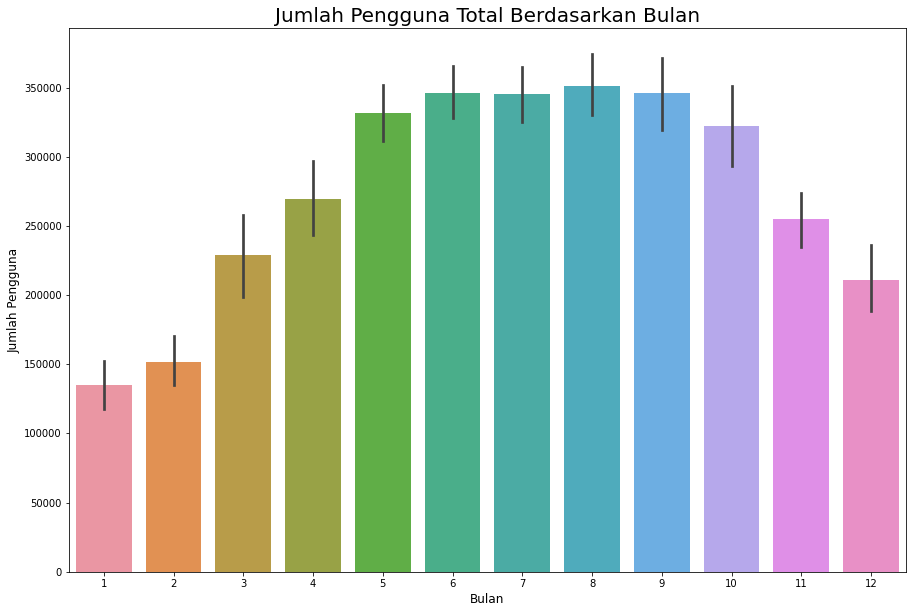

In [ ]:
# Grafik jumlah pengguna di setiap bulan
plt.figure(figsize=(15,10))
sns.barplot(data=df_day,
            x='month',
            y='total_count',
            estimator = np.sum
            )
plt.title('Jumlah Pengguna Total Berdasarkan Bulan', size = 20)
plt.xlabel('Bulan', size = 12)
plt.ylabel('Jumlah Pengguna', size = 12)
plt.show()

Melalui grafik ini kita dapat mengamati bahwa tidak banyak pengguna pada bulan Januari dan Februari kalau dibandingkan dengan bulan yang lain. **Banyaknya pengguna total terjadi pada bulan Mei sampai Oktober, dimana jumlah total melebihi 300000 pengguna.** 

Jadi dapat kita tarik kesimpulan bahwa fasilitas untuk bulan Mei sampai Oktober harus disediakan lebih banyak untuk memenuhi demand yang ada. Sedangkan pada bulan Januari dan Februari dapat melakukan perbaikan fasilitas di saat jumlah demand tidak terlalu banyak.

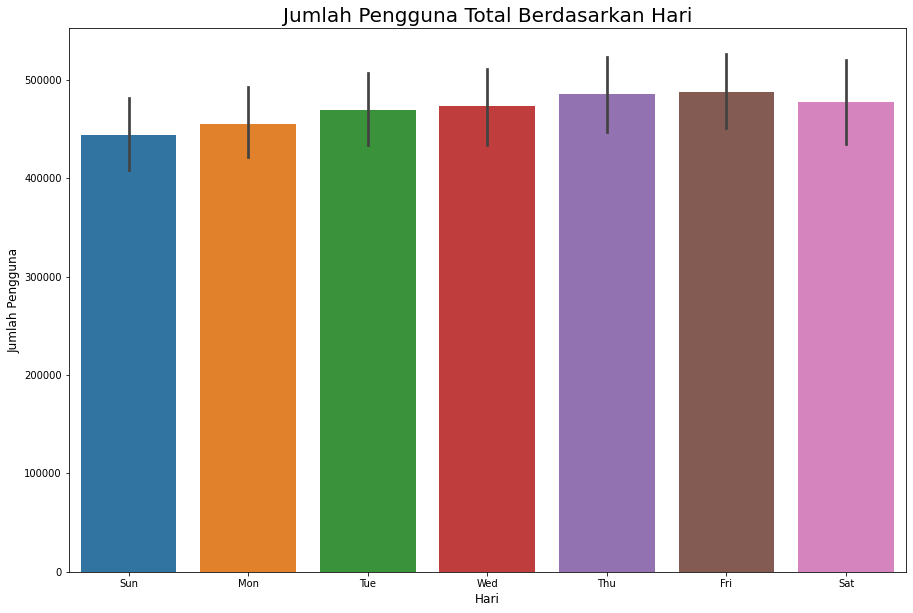

In [ ]:
# Grafik jumlah pengguna berdasarkan hari
plt.figure(figsize=(15,10))
sns.barplot(data=df_day,
            x='weekday',
            y='total_count',
            estimator = np.sum
            )
plt.title('Jumlah Pengguna Total Berdasarkan Hari', size = 20)
plt.xlabel('Hari', size = 12)
plt.ylabel('Jumlah Pengguna', size = 12)
plt.xticks([0,1,2,3,4,5,6],['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

Jumlah pengguna per harinya tidak menunjukkan perbedaan yang cukup besar antar data per hari. Tapi dari grafik ini kita dapat mengamati bahwa jumlah pengguna paling sedikit ada di hari Minggu dengan total sebesar 444027 pengguna dan paling banyak di hari Jumat dengan total 487790 pengguna.

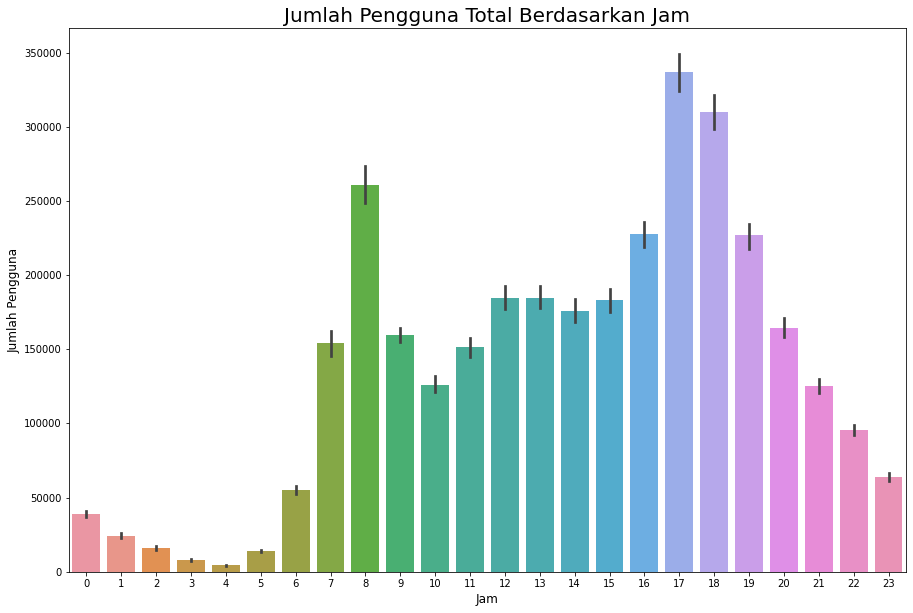

In [ ]:
# Grafik jumlah pengguna berdasarkan jam
plt.figure(figsize=(15,10))
sns.barplot(data=df_hour,
            x='hour',
            y='total_count',
            estimator = np.sum
            )
plt.title('Jumlah Pengguna Total Berdasarkan Jam', size = 20)
plt.xlabel('Jam', size = 12)
plt.ylabel('Jumlah Pengguna', size = 12)
plt.show()

Sedangkan jika mengamati jumlah pengguna dalam setiap jamnya maka akan terlihat bahwa jumlah terbanyak ada di jam 8 pagi untuk waktu di pagi hari. Lalu ketika sore hari di 5 dan 6 sore, terjadi peningkatan yang cukup drastis dimana jumlah pengguna paling banyak ada di sore hari. 

Melalui analisa ini kita dapat menyimpulkan bahwa banyaknya pengguna di jam-jam berikut terjadi karena ini adalah jam masuk kerja dan pulang kerja yang selaras dengan adanya jumlah pengguna registered yang lebih banyak dibandingkan pengguna casual.

#### Users Count vs Season Analysis

In [ ]:
# Menghitung jumlah pengguna total, casual dan registered dikelompokkan berdasarkan tahun dan musim
df_user_season = df_day.groupby(['year','season']).sum()[['casual','registered','total_count']]
df_user_season

casual  registered  total_count
year season                                 
0    1        21425      128575       150000
     2        77564      269752       347316
     3        95450      324200       419650
     4        52813      273324       326137
1    1        39197      282151       321348
     2       125958      445315       571273
     3       130641      510838       641479
     4        76969      438507       515476

Berdasarkan tabel diatas,  dari musim dingin (winter:1) ke musim semi (spring:2) terjadi peningkatan yang signifikan jumlah pengguna sekitar 2 kali lipat dibandingan peralihan musim lainnya. Ini dapat dijadikan acuan/tanda untuk meningkatkan jumlah fasilitas seperti sepeda guna memenuhi *demand* yang begitu tinggi pada saat memasuki musim semi dan puncaknya ketika musim panas.

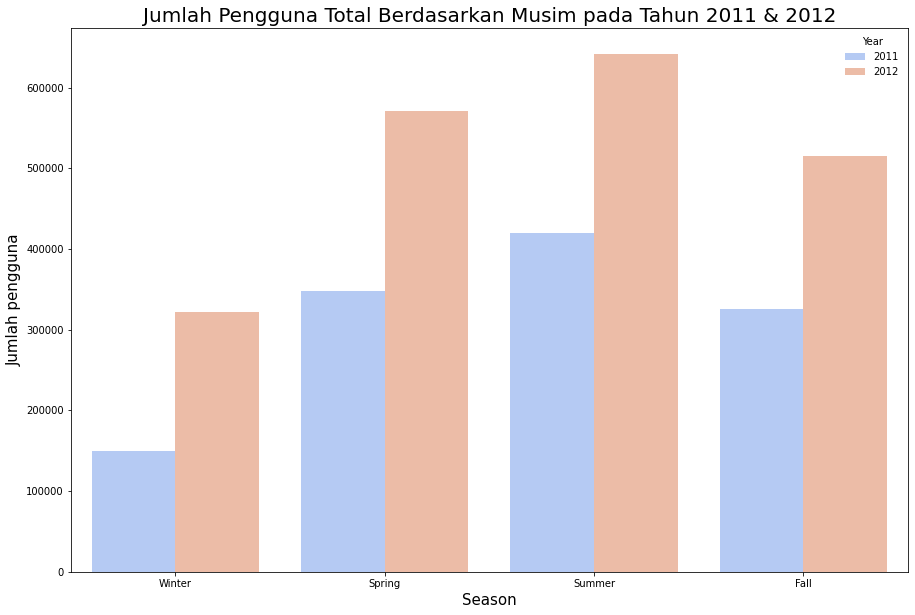

In [ ]:
# Grafik jumlah pengguna total dikelompokkan berdasarkan tahun dan musim 
plt.figure(figsize=(15,10))
sns.barplot('season','total_count',hue='year', data=df_day, palette='coolwarm', ci=None, estimator=np.sum)
plt.xlabel('Season', size = 15)
plt.ylabel('Jumlah pengguna', size = 15)
plt.title('Jumlah Pengguna Total Berdasarkan Musim pada Tahun 2011 & 2012', size = 20)
plt.xticks([0,1,2,3],['Winter', 'Spring', 'Summer', 'Fall'])
plt.legend(title='Year', loc='best', labels=['2011', '2012'], frameon=False)
plt.show()

Melalui analisa jumlah pengguna berdasarkan musim, kita dapat mengamati bahwa pada musim winter (dingin) jumlah pengguna mengalami penurunan drastis dimana pada musim dingin pastinya tidak banyak orang yang akan menyewa sepeda dikarenakan cuaca dan suhu yang sangat dingin. Sedangkan di musim summer (panas) jumlah pengguna sangat tinggi baik pengguna Casual maupun Registered. Hal ini dibuktikan adanya korelasi positif yang cukup kuat antara jumlah pengguna dan suhu berdasarkan tabel korelasi.

Dapat kita simpulkan bahwa pada musim panas demand untuk menyewa sepeda sangatlah tinggi (32% dari total demand) dan di musim dingin demandnya tidak terlalu tinggi (14% dari total demand) sehingga fasilitas perlu kita sediakan lebih di musim panas dan ketika musim dingin kita dapat melakukan perbaikan fasilitas

#### Users Count vs Weather Analysis

In [ ]:
# Menghitung jumlah pengguna total, casual dan registered dikelompokkan berdasarkan keadaan cuaca
df_user_weathersit = df_hour[['casual', 'registered','total_count']].groupby(df_hour['weathersit']).sum()
df_user_weathersit

,casual,registered,total_count
weathersit,,,
1,462745,1875428,2338173
2,134481,661471,795952
3,22783,135548,158331
4,8,215,223


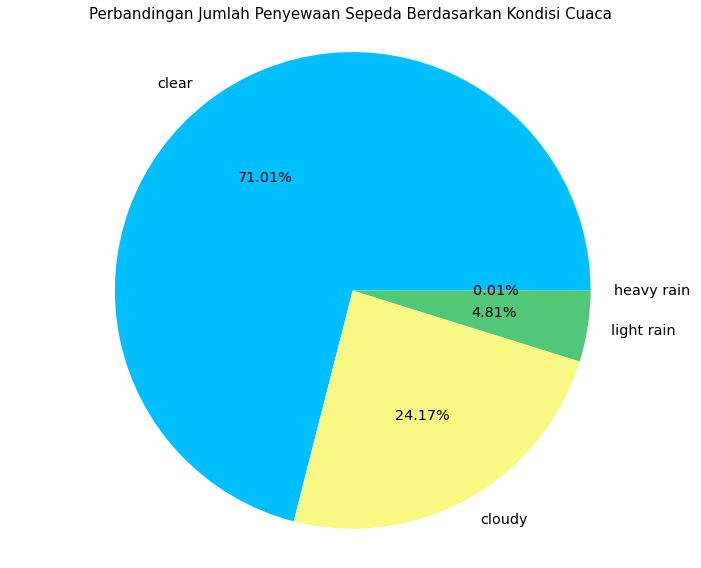

In [ ]:
# Pie chart perbandingan jumlah penyewaan sepeda berdasarkan kondisi cuaca
plt.figure(figsize=(10,8))
labels = ['clear','cloudy','light rain','heavy rain']
colors = ['#00BFFF', '#FAF884', '#50C878', '#806517']
plt.pie(df_user_weathersit['total_count'],
        labels = labels,
        autopct='%.2f%%',
        colors=colors,
        textprops={'size': 'x-large'})
plt.title('Perbandingan Jumlah Penyewaan Sepeda Berdasarkan Kondisi Cuaca', size=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

Melalui tabel dan grafik di atas kita dapat mengamati jumlah pengguna berdasarkan kondisi cuaca yang ada. Mayoritas pengguna menyewa di saat cuaca cerah (lebih dari 70% dari jumlah pengguna total) dilanjutkan oleh cuaca berawan (24%) dan bisa kita lihat bahwa ketika hujan lebat/deras hampir tidak ada pengguna yang menyewa sepeda seperti dapat dilihat dari pie chart di atas yang menunjukkan nilai 0.01% dari jumlah pengguna total. 

#### Workingday vs Not Workingday Analysis

In [ ]:
# Rata-rata jumlah penyewaan sepeda di hari kerja
print('Workingday')
print('All: ' + str(round(df_day[df_day['workingday']==1]['total_count'].mean(),2)))
print('Casual: ' + str(round(df_day[df_day['workingday']==1]['casual'].mean(),2)))
print('Registered: ' + str(round(df_day[df_day['workingday']==1]['registered'].mean(),2)),'\n')

# Rata-rata jumlah penyewaan sepeda di hari kerja
print('Not Workingday')
print('All: ' + str(round(df_day[df_day['workingday']==0]['total_count'].mean(),2)))
print('Casual: ' + str(round(df_day[df_day['workingday']==0]['casual'].mean(),2)))
print('Registered: ' + str(round(df_day[df_day['workingday']==0]['registered'].mean(),2)))

Workingday
All: 4584.82
Casual: 606.57
Registered: 3978.25 

Not Workingday
All: 4330.17
Casual: 1371.13
Registered: 2959.03


In [ ]:
table = pd.DataFrame({
                    'Workingday' : [4584.82, 606.57, 3978.25], 
                    'Not Workingday' : [4330.17, 1371.13, 2959.03]
}, index = ['All', 'Casual', 'Registered'])
table

,Workingday,Not Workingday
All,4584.82,4330.17
Casual,606.57,1371.13
Registered,3978.25,2959.03


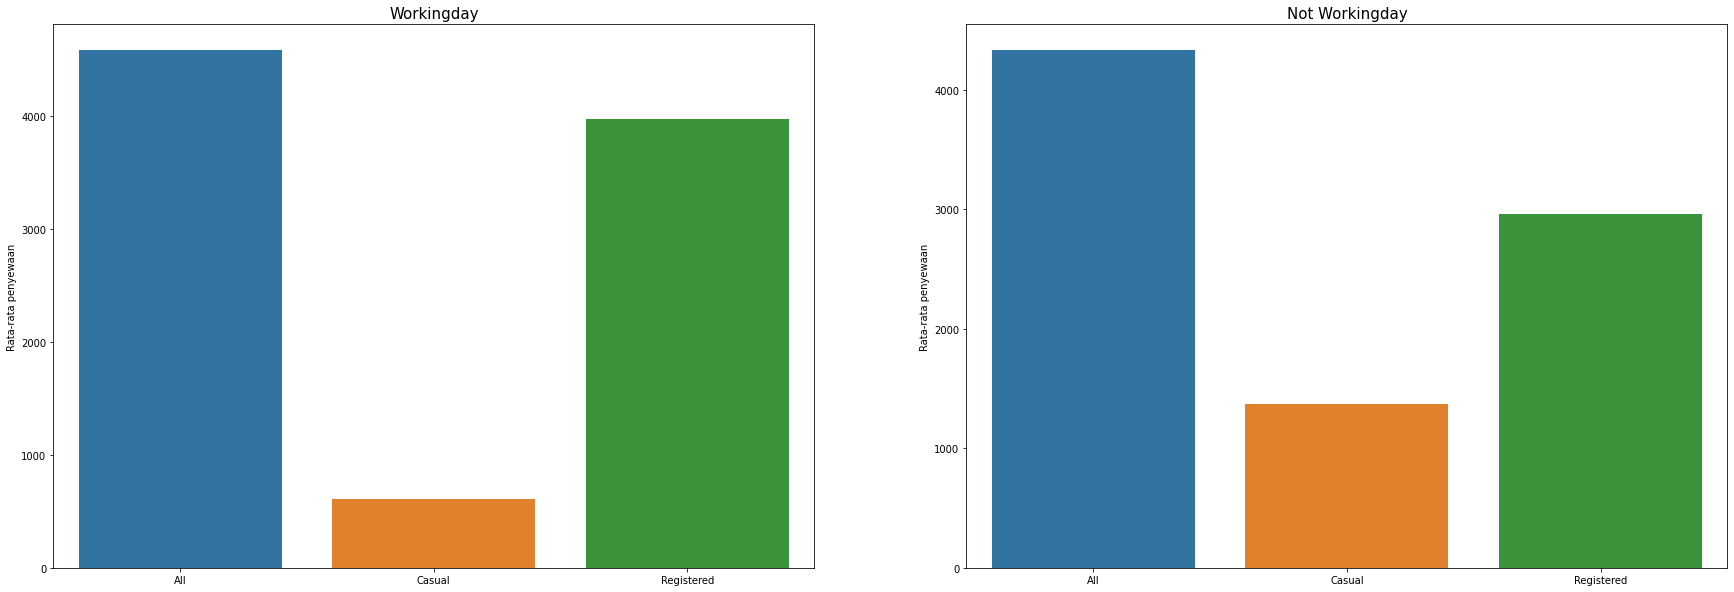

In [ ]:
# Bar plot yang menggambarkan perbandingan rata-rata jumlah pengguna berdasarkan hari kerja dan bukan hari kerja
plt.figure(figsize=(30,10))
plt.subplot(121)
sns.barplot(data=table, x = table.index, y='Workingday')
plt.ylabel('Rata-rata penyewaan')
plt.title('Workingday', size = 15)

plt.subplot(122)
sns.barplot(data=table, x = table.index, y='Not Workingday')
plt.ylabel('Rata-rata penyewaan')
plt.title('Not Workingday', size = 15)

plt.show()

Melalui tabel dan grafik di atas, kita dapat mengamati bahwa pada hari kerja 
maupun hari libur jumlah total pengguna akan lebih kurang sama dan tidak memiliki perbedaan yang sangat besar, ditunjukkan dari perbedaan nilai rata-rata sebesar 254.65 pengguna per hari. 

Namun kita dapat mengamati bahwa memang jumlah pengguna Registered lebih banyak di hari kerja yang dapat kita simpulkan bahwa kebanyakan pengguna Registered menyewa sepeda untuk transportasi menuju tempat bekerja. Sedangkan kebalikannya penguna Casual bertambah menjadi 2 kali lipat di hari libur dimana kita dapat berasumsi bahwa banyak turis atau pengunjung di hari libur yang menyewa sepeda.

Walaupun pada hari libur jumlah pengguna Registered menurun tetapi nilai rata-ratanya tetap lebih banyak dibandingkan dengan pengguna Casual.    

In [ ]:
# Menghitung jumlah pengguna casual, registered, dan total dikelompokkan berdasarkan jam pada hari kerja
df_hour_workingday = df_hour[(df_hour['workingday']==1)|(df_hour['holiday']==0)].groupby('hour')[['casual', 'registered', 'total_count']].sum()
df_hour_workingday

,casual,registered,total_count
hour,,,
0,7071,30852,37923
1,4518,18829,23347
2,3247,12570,15817
3,1834,6131,7965
4,838,3473,4311
5,979,13059,14038
6,2943,51595,54538
7,7859,144587,152446
8,15265,242155,257420


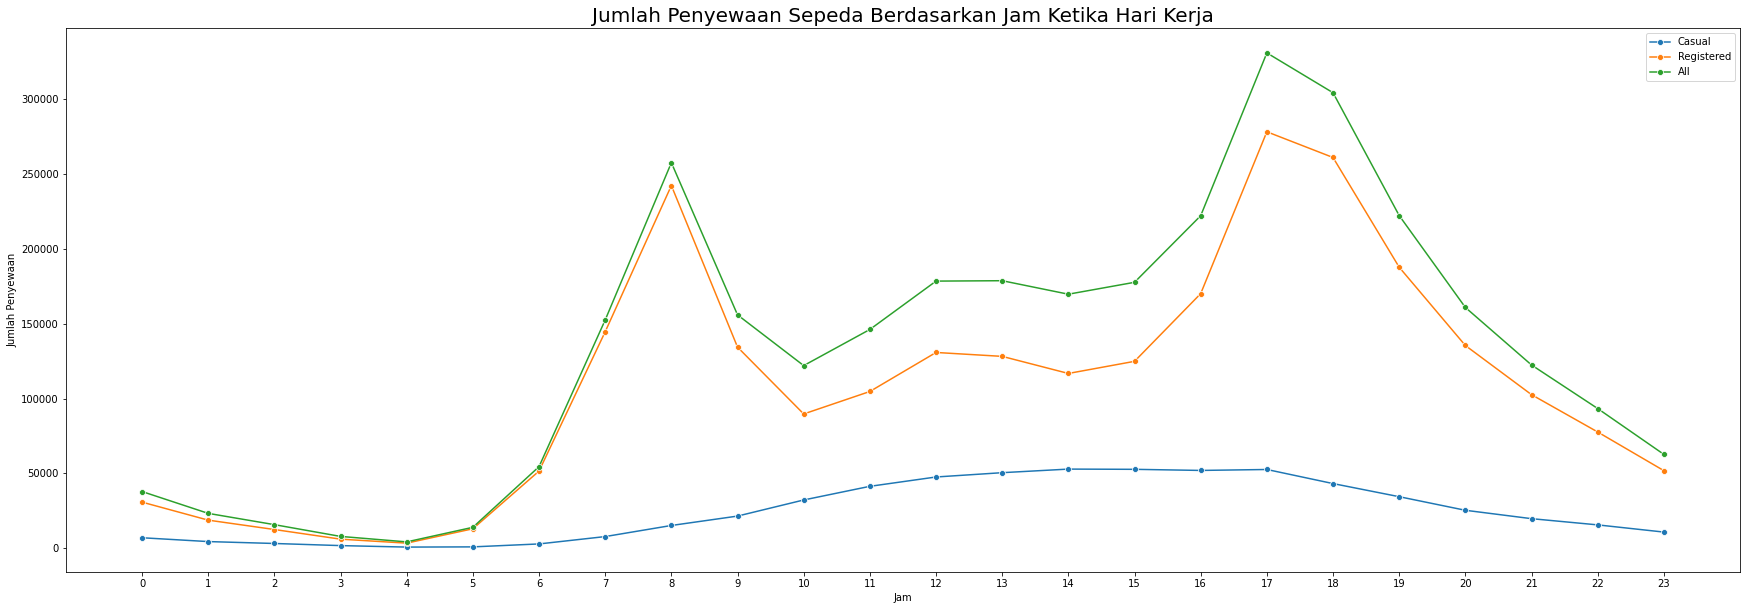

In [ ]:
# Grafik jumlah penyewaan sepeda berdasarkan jam di hari kerja 
plt.figure(figsize=(30,10))
sns.lineplot(data = df_hour_workingday, x ='hour', y ='casual',  marker='o', label ='Casual')
sns.lineplot(data = df_hour_workingday, x ='hour', y ='registered',  marker='o', label ='Registered')
sns.lineplot(data = df_hour_workingday, x ='hour', y ='total_count',  marker='o', label ='All')
plt.title('Jumlah Penyewaan Sepeda Berdasarkan Jam Ketika Hari Kerja', size=20)
plt.xlabel('Jam')
plt.ylabel('Jumlah Penyewaan')
plt.xticks(np.arange(0,24,1))
plt.show()

Melalui grafik di atas kita dapat mengamati bahwa pada hari kerja di jam 8 pagi, 5 sore dan 6 sore adalah 3 periode dengan jumlah pengguna tertinggi dengan jumlah di atas 250 ribu pengguna total dan mayoritasnya adalah jumlah pengguna registered. 

Untuk pengguna Casual sendiri, kita dapat mengamati bahwa jam yang cukup ramai dengan pengguna Casual ada dari jam 12 siang sampai 5 sore dengan jumlah di atas 50 ribu pengguna. Maka kalau kita ingin menerapkan business plan untuk meningkatkan pendapatan dari penguna Casual, kita dapat melakukannya pada jam-jam tersebut. 

In [ ]:
# Menghitung jumlah pengguna casual, registered, dan total dikelompokkan berdasarkan jam pada bukan hari kerja (weekend dan hari libur)
df_hour_notworkingday = df_hour[(df_hour['workingday']==0)|(df_hour['holiday']==1)].groupby('hour')[['casual', 'registered', 'total_count']].sum()
df_hour_notworkingday

,casual,registered,total_count
hour,,,
0,3829,17055,20884
1,2876,13111,15987
2,2371,9752,12123
3,1465,4386,5851
4,514,1362,1876
5,383,1546,1929
6,875,3417,4292
7,1988,8039,10027
8,4718,19688,24406


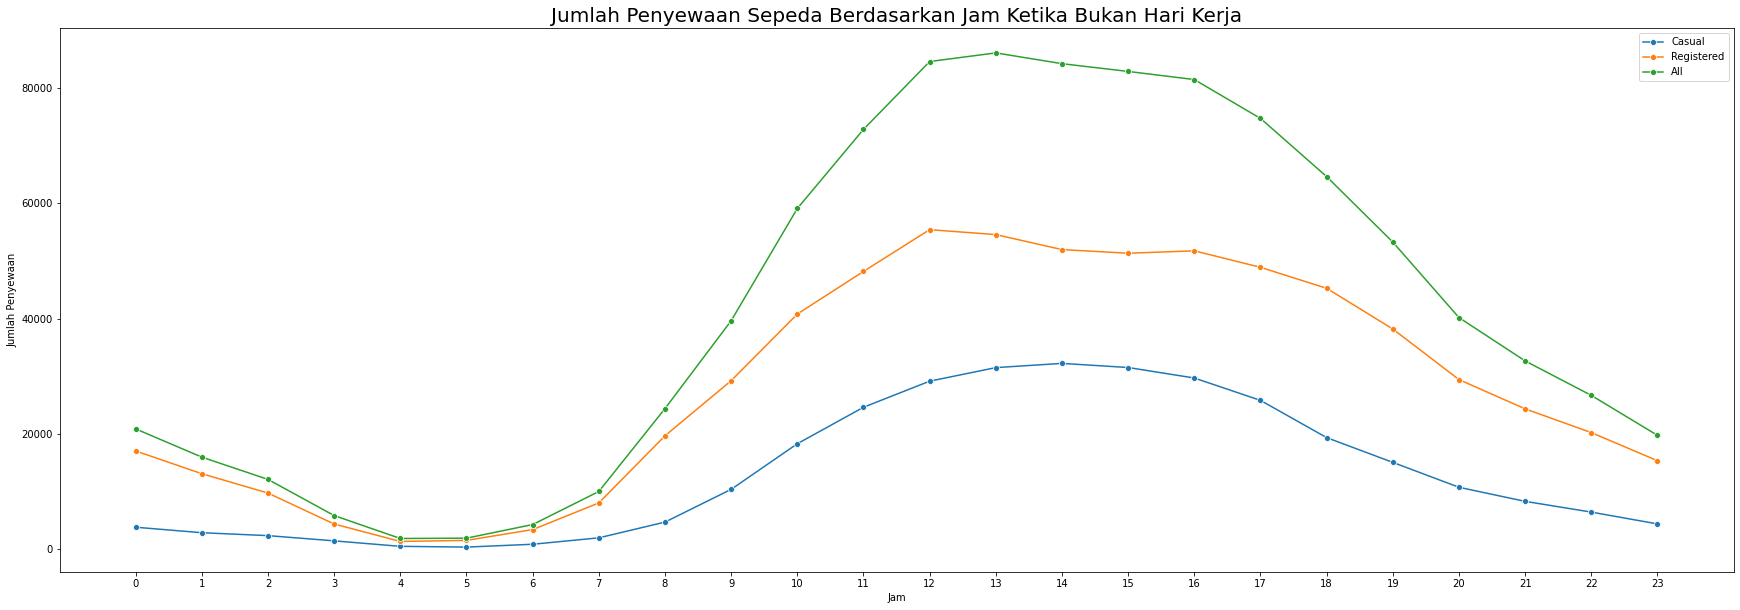

In [ ]:
# Grafik jumlah penyewaan sepeda berdasarkan jam di bukan hari kerja (weekend dan hari libur)
plt.figure(figsize=(30,10))
sns.lineplot(data = df_hour_notworkingday, x ='hour', y ='casual',  marker='o', label ='Casual')
sns.lineplot(data = df_hour_notworkingday, x ='hour', y ='registered',  marker='o', label ='Registered')
sns.lineplot(data = df_hour_notworkingday, x ='hour', y ='total_count',  marker='o', label ='All')
plt.title('Jumlah Penyewaan Sepeda Berdasarkan Jam Ketika Bukan Hari Kerja', size=20)
plt.xlabel('Jam')
plt.ylabel('Jumlah Penyewaan')
plt.xticks(np.arange(0,24,1))
plt.show()

Sedangkan di hari libur kita dapat melihat banyaknya pengguna terjadi dari jam 11 pagi sampai 6 sore dengan jumlah pengguna total di atas 60 ribu pengguna.

Ramainya pengguna Casual dan Registered juga ada di periode waktu yang sama pada hari libur atau weekend.

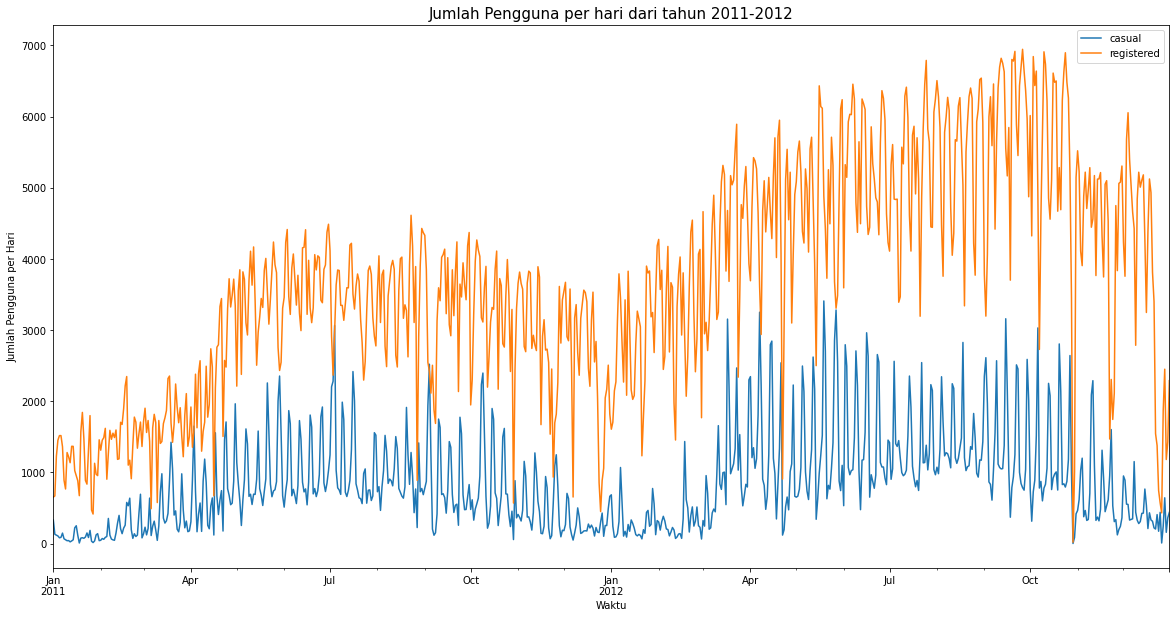

In [ ]:
# Casual vs Registered Users Analysis
df_day[['casual','registered']].groupby(df_day['date']).sum().plot(figsize=(20,10))
plt.title('Jumlah Pengguna per hari dari tahun 2011-2012', size=15)
plt.xlabel('Waktu')
plt.ylabel('Jumlah Pengguna per Hari')
plt.show()

Melalui analisa di atas kita dapat mendapat gambaran yang lebih jelas mengenai kenaikan dari pengguna Registered dari tahun 2011 ke tahun 2012. Seperti yang dapat diamati dari grafik di atas bahwa jumlah pengguna bisa mencapai jumlah di atas 6000 untuk pengguna Registered sedangkan untuk pengguna casual hanya di kisaran 2000-3000. 

### Machine Learning
Model Machine Learning digunakan untuk memprediksi jumlah pengguna di masa yang akan datang. Disini kita mencoba menggunakan 2 model Machine Learning yaitu:
1. Time Series Model with Exogenous Variable
2. Facebook Prophet

#### Time Series Model with Exogenous Variable
*Time Series Model with Exogenous Variable* merupakan metode yang memanfaatkan variabel eksternal dalam proses pemodelannya. Salah satu syarat yang harus dipenuhi, ketika kita ingin menggunakan variabel eksternal adalah data tersebut sudah tersedia ketika nilai forecasting dibutuhkan. Variabel eksternal dalam pemodelan ini terdiri dari data musim, kondisi cuaca, temperatur, kelembapan udara dan kecepatan angin.

##### Preprocessing


In [ ]:
# Melakukan proses encoding variabel kategorik dengan menggunakan One Hot Encoding
cat_features = ['month','weekday','season', 'weathersit']

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),cat_features)],
                                 remainder = 'passthrough'
                                )

*Encoding* merupakan suatu metode yang dapat diterapkan untuk merepresentasikan variabel kategorik dalam machine learning. Dalam pemodelan ini variabel kategorik 'month', 'weekday', 'season' dan 'weathersit' akan di-*encoding* menggunakan metode One Hot Encoding. Dalam One Hot Encoding, kita memecah suatu variabel kategorik menjadi beberapa variabel yang nilainya satu atau nol atau disebut juga *dummy variable*. Penggunaan ***drop = 'first'*** perlu dilakukan karena kita menggunakan model regresi linear. Khusus linear model, maksimal banyaknya *dummy variable* yang perlu dibuat adalah banyaknya kategori dikurangi satu. Hal ini dilakukan untuk menghindari masalah multikolinearitas. Pada variabel kategorik 'year', 'holiday' dan 'workingday' tidak dilakukan proses encoding karena sudah memiliki nilai nol dan satu.

##### Data Splitting

Dalam proses data splitting time series, kita tidak dapat membagi menjadi beberapa bagian secara acak karena data kita memiliki urutan yang bermakna. Data splitting secara acak tidak akan mencerminkan forecasting yang hendak kita lakukan. Untuk itu, proses splitting perlu dilakukan dengan tetap mempertahankan urutan data dan data dibagi pada titik tertentu. Pembagian datanya yaitu data dari tanggal 1 Januari 2011 - 30 Juni 2012 dialokasikan untuk **training set**, sedangkan data dari tanggal 1 Juli 2012 - 31 Desember 2012 dialokasikan untuk **test set**.

In [ ]:
# Data untuk training menggunakan data dari tanggal 1 Januari 2011 - 30 Juni 2012
df_train = df_day[df_day['date'] < '2012-07-01'] 
X_train = df_train[['year','month', 'holiday', 'weekday', 'workingday', 'season', 'weathersit', 'temperature', 'humidity', 'windspeed']]
y_train = df_train['total_count']

# Data untuk test menggunakan data dari tanggal 1 Juli 2012 - 31 Desember 2012
df_test = df_day[df_day['date'] >= '2012-07-01']
X_test = df_test[['year','month', 'holiday', 'weekday', 'workingday', 'season', 'weathersit', 'temperature', 'humidity', 'windspeed']]
y_test = df_test['total_count']

##### Modeling

In [ ]:
# Melakukan proses fitting dan transform
X_train_preprocessed = transformer.fit_transform(X_train) # Proses fitting dan transform untuk X_train. Proses .fit hanya diterapkan untuk training set saja
X_test_preprocessed = transformer.transform(X_test) # Proses .transform pada X_test


In [ ]:
# Melakukan proses modeling : Linear Regression
model = LinearRegression()
model.fit(X_train_preprocessed, y_train) # Fitting model menggunakan data training set (X_train yang digunakan adalah X_train yang sudah di-preprocessing)
y_pred_train = model.predict(X_train_preprocessed) # memprediksi nilai y berdasarkan x_train_preprocessed
y_pred = model.predict(X_test_preprocessed) # memprediksi nilai y berdasarkan x_test_preprocessed

Untuk memodelkan data time series digunakan model linear regression karena model ini memiliki kemampuan untuk melakukan ekstrapolasi. Kemampuan ekstrapolasi dibutuhkan dalam forecasting karena digunakan untuk memprediksi suatu nilai di luar selang amatan.

In [ ]:
# Regression metrics : digunakan untuk mengevaluasi model
def regression_results(y_true, y_pred):
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2 = metrics.r2_score(y_true, y_pred)
        
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('R-squared: ', round(r2,4))

    # Membuat scatterplot nilai prediksi dengan residual(selisih nilai aktual dengan nilai prediksi)
    plt.figure(figsize=(15,8))
    sns.scatterplot(y_pred,y_true-y_pred)
    plt.xlabel('Prediksi')
    plt.ylabel('Residual')
    plt.show()

MAE:  489.87
MSE:  435019.2651
RMSE:  659.5599
R-squared:  0.8512


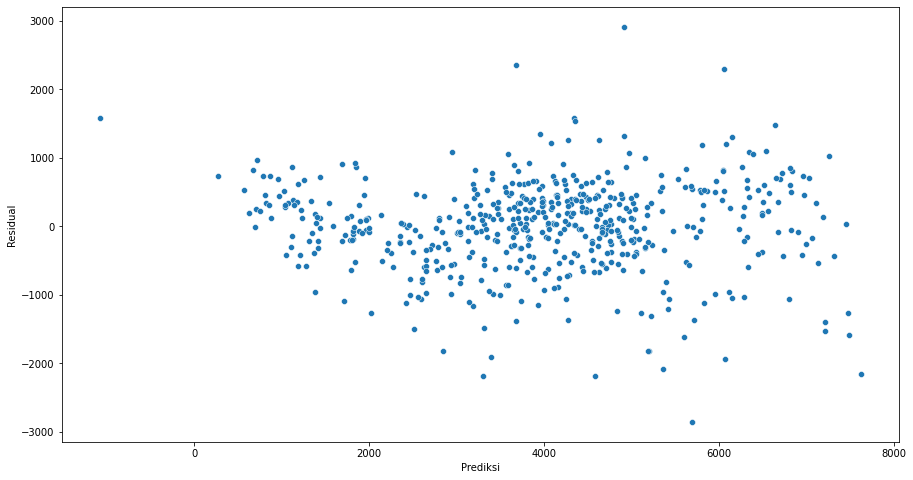

In [ ]:
# Melakukan evaluasi model berdasarkan training set dengan metrics yang sudah ditentukan
regression_results(y_train, y_pred_train)

Grafik di atas menunjukkan persebaran nilai prediksi dengan nilai residual (selisih nilai aktual dengan nilai prediksi) pada training model. Grafik menunjukkan residual sudah berkisar di nilai nol yang menunjukkan hasil prediksi sudah baik, namun ada beberapa amatan dimana data point yang hasil prediksinya meleset jauh (ditunjukan oleh data point yang nilai residualnya jauh dari nol).

MAE:  808.4427
MSE:  1140184.5125
RMSE:  1067.7942
R-squared:  0.6239


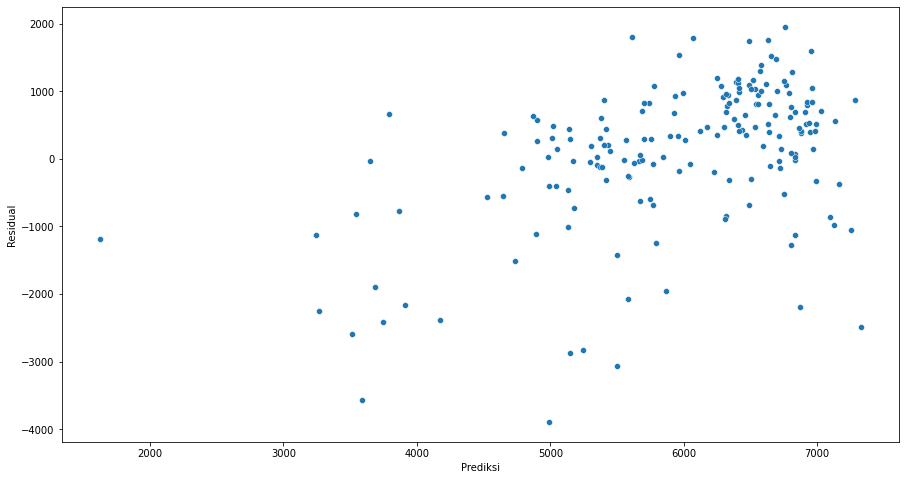

In [ ]:
# Melakukan evaluasi model berdasarkan test set dengan metrics yang sudah ditentukan (mengecek performa akhir dari model)
regression_results(y_test, y_pred)

Grafik di atas menunjukkan persebaran nilai prediksi dengan residual pada test set. Grafik menunjukkan residual sudah berkisar di nilai nol namun ada cukup banyak amatan dimana data point yang hasil prediksinya meleset jauh (ditunjukan oleh data point yang nilai residualnya jauh dari nol). Hal ini menunjukkan performa model pada test set lebih buruk dibandingkan performa model pada training set dibuktikan dengan nilai r-squared yang lebih rendah yaitu 0.6239. Performa akhir model menunjukkan nilai r-squared 0.6239 yang menandakan bahwa variasi nilai y yang dapat dijelaskan oleh model hanya 62.39%.

In [ ]:
# Menambahkan kolom hasil prediksi ke dataset test
df_test['y_pred'] = y_pred
df_test

,date,season,year,month,holiday,weekday,workingday,weathersit,temperature,humidity,windspeed,casual,registered,total_count,y_pred
547,2012-07-01,3,1,7,0,0,0,1,0.815833,0.518750,0.168529,1421,4110,5531,6807.625834
548,2012-07-02,3,1,7,0,1,1,1,0.781667,0.447083,0.195267,904,5323,6227,6751.497820
549,2012-07-03,3,1,7,0,2,1,1,0.780833,0.492083,0.126237,1052,5608,6660,6993.246658
550,2012-07-04,3,1,7,1,3,0,1,0.789167,0.538750,0.134950,2562,4841,7403,6414.614381
551,2012-07-05,3,1,7,0,4,1,1,0.827500,0.457917,0.194029,1405,4836,6241,7093.628968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,1,1,12,0,4,1,2,0.254167,0.652917,0.350133,247,1867,2114,3243.862552
727,2012-12-28,1,1,12,0,5,1,2,0.253333,0.590000,0.155471,644,2451,3095,3868.562931
728,2012-12-29,1,1,12,0,6,0,2,0.253333,0.752917,0.124383,159,1182,1341,3749.785785
729,2012-12-30,1,1,12,0,0,0,1,0.255833,0.483333,0.350754,364,1432,1796,3688.299813


In [ ]:
# Tabel perbandingan nilai aktual dan prediksi beserta nilai residualnya
df_results = pd.DataFrame({
    'Actual': y_test.tolist(),
    'Prediction': y_pred.tolist()
})

df_results['Residual'] = df_results['Actual'] - df_results['Prediction']
df_results

,Actual,Prediction,Residual
0,5531,6807.625834,-1276.625834
1,6227,6751.497820,-524.497820
2,6660,6993.246658,-333.246658
3,7403,6414.614381,988.385619
4,6241,7093.628968,-852.628968
...,...,...,...
179,2114,3243.862552,-1129.862552
180,3095,3868.562931,-773.562931
181,1341,3749.785785,-2408.785785
182,1796,3688.299813,-1892.299813


In [ ]:
# Grafik nilai 'total_count' hasil prediksi dengan nilai sebenarnya
fig = go.Figure([go.Scatter(name = 'true',x=df_test['date'], y=df_test['total_count'])])
fig.add_trace(go.Scatter(name = 'prediction',x=df_test['date'], y=df_test['y_pred']))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Grafik di atas menggambarkan nilai prediksi dan nilai sebenarnya berdasarkan waktu. Dapat dilihat bahwa garis nilai prediksi masih belum cukup mendekati garis nilai sebenarnya.

Hyperparameter Tuning

In [ ]:
# Menyiapkan parameter dari linear regression
paramLinReg = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5) # cross validasi untuk timeseries
LinReg_param = GridSearchCV(LinearRegression(), paramLinReg, cv=tscv, n_jobs=-1, verbose=1)# melakukan hyperparameter tuning dangan metode Grid Search(mencoba seluruh kombinasi hyperparameter)
LinReg_param.fit(X_train_preprocessed, y_train)
print(LinReg_param.score(X_test_preprocessed, y_test))
print(LinReg_param.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


0.6200471263407317
{'fit_intercept': False, 'normalize': True}


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished


MAE:  808.3742
MSE:  1151842.769
RMSE:  1073.2394
R-squared:  0.62


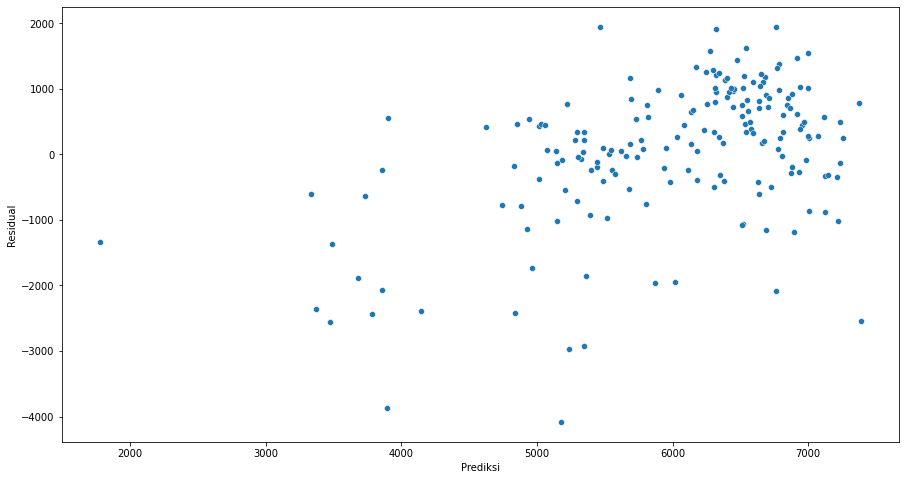

In [ ]:
# Melakukan pemodelan linear regression berdasarkan best estimator
LinReg_best = LinReg_param.best_estimator_
LinReg_best.fit(X_train_preprocessed, y_train)
y_pred2 = LinReg_best.predict(X_test_preprocessed)
LinReg_best_acc = regression_results (y_test, y_pred2)

Setelah dilakukan hyperparameter tuning pada model linear regression, hasil yang didapat tidak jauh berbeda dengan sebelum dilakukan tuning, ada sedikit penurunan nilai pada r-squared menjadi 0.6200 dan bertambahnya nilai MSE serta RMSE. Oleh karena itu, model yang digunakan adalah model sebelum dilakukan hyperparameter tuning dengan nilai r-squared sebesar 0.6239.

Analisis Model

- Penggunaan Time Series Model with Exogenous Variable pada kasus ini selain bergantung pada variabel waktu juga bergantung pada variabel eksternal seperti  kondisi cuaca, temperatur, kelembapan, dan kecepatan angin. Variabel eksternal tersebut nilainya baru bisa diukur pada saat kejadian (secara aktual). Jadi kalau menggunakan model ini untuk prediksi maka akan menggunakan nilai prediksi/perkiraan dari variabel eksternal tersebut. Nilai prediksi bergantung pada seberapa tepat prediksi nilai variabel eksternal seperti prediksi cuaca, suhu, kelembapan dan kecepatan angin. 
-Untuk meningkatkan performa model dibutuhkan data yang lebih banyak, sebab model ini dibuat dari data yang relatif sedikit yaitu data dengan jangka waktu 2 tahun.

#### Facebook Prophet
Prophet merupakan salah satu model untuk time series forecasting yand dibuat oleh tim Data Science dari Facebook.

Model ini sangat baik untuk digunakan dengan data yang didasari oleh efek musim dan juga efek hari libur. Model ini juga dapat menangani outlier dengan baik.

##### Preprocessing
Tahan Preprocessing perlu dilakukan untuk membuat dataframe baru yang dibutuhkan dalam model FB Prophet.

In [ ]:
# Prophet membutuhkan input yang berupa dataframe dengan 2 kolom saja: ds dan y. Dimana ds adalah datestamp yang harus mempunyai format Datetime dan y adalah variabel numerik yang ingin kita prediksi
# Karena kita mau memprediksi jumlah pengguna total maka value y = total_count
df_prophet = df_day.filter(['date','total_count'], axis=1)
df_prophet.columns = ['ds','y']
df_prophet.head()

,ds,y
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


##### Data Splitting

In [ ]:
# Fitting model sebelum prediksi dilakukan
m = Prophet(interval_width=0.95) #setting confidence interval of 95%, by default is 80%
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##### Modelling

In [ ]:
# Membuat data tanggal yang akan datang untuk periode 365 hari/1 tahun ke depan
future_dates = m.make_future_dataframe(periods=365) #period menentukan periode yang ingin digunakan untuk prediksi

# Membuat prediksi jumlah pengguna total (value y) dengan periode waktu yang akan datang
prediction = m.predict(future_dates)
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1091,2013-12-27,8119.408718,3619.683352,7639.416642,7891.909858,8353.729109,-2467.130671,-2467.130671,-2467.130671,166.811059,166.811059,166.811059,-2633.941731,-2633.941731,-2633.941731,0.0,0.0,0.0,5652.278047
1092,2013-12-28,8123.992194,3618.050161,7509.100716,7895.616782,8359.406971,-2555.007189,-2555.007189,-2555.007189,65.652427,65.652427,65.652427,-2620.659616,-2620.659616,-2620.659616,0.0,0.0,0.0,5568.985005
1093,2013-12-29,8128.575670,3211.451612,7163.230131,7899.360707,8365.072883,-2856.778407,-2856.778407,-2856.778407,-261.994109,-261.994109,-261.994109,-2594.784298,-2594.784298,-2594.784298,0.0,0.0,0.0,5271.797263
1094,2013-12-30,8133.159146,3548.041328,7342.611262,7903.122192,8370.300809,-2715.598973,-2715.598973,-2715.598973,-158.685057,-158.685057,-158.685057,-2556.913915,-2556.913915,-2556.913915,0.0,0.0,0.0,5417.560173
1095,2013-12-31,8137.742621,3722.147123,7631.102641,7906.883678,8375.528734,-2504.547994,-2504.547994,-2504.547994,3.315108,3.315108,3.315108,-2507.863102,-2507.863102,-2507.863102,0.0,0.0,0.0,5633.194627


Data frame di atas merupakan hasil dari fungsi predict yang terdapat di model FB Prophet. Data yang memprediksi nilai output yang mau kita prediksi ditunjukan pada kolom "yhat". 

In [ ]:
# Membuat plot hasil dari prediksi di tahun depan dengan plotly
plot_plotly(m, prediction)

Melalui grafik ini kita dapat melihat prediksi dari jumlah pengguna total Bike-Sharing system untuk tahun 2013. Data pun dapat dibagi secara mingguan, bulanan, 6 bulan dan tahunan.

Sedikit penjelasan mengenai grafik ini, untuk titik berwarna hitam adalah data dari dataset yang kita gunakan. Garis biru tua merupakan proyeksi dari prediksi dari model ini. Area berwarna biru muda adalah trend space.

Melalui grafik ini kita dapat mengamati bahwa demand akan meningkat di tahun berikutnya dengan mengikut trend yang sama dari tahun-tahun berikutnya.

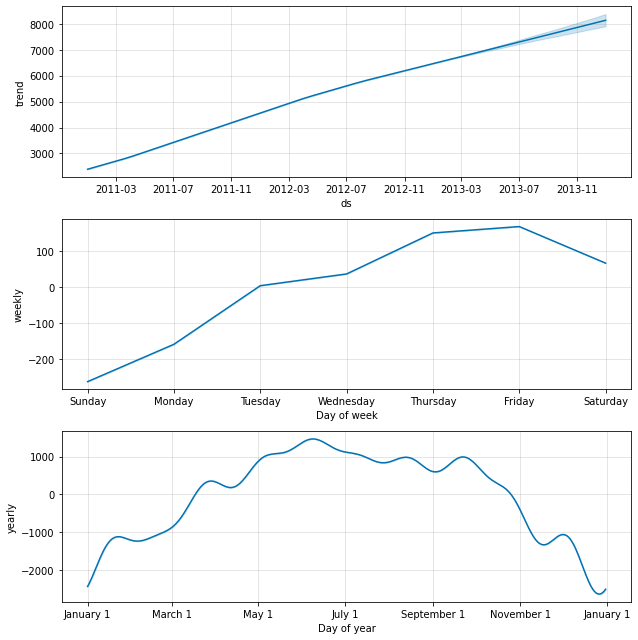

In [ ]:
# Memvisualisasi setiap komponen dari hasil prediksi (trend, weekly, yearly)
m.plot_components(prediction);

Melalui grafik di atas kita dapat mengamati trend yang terjadi baik secara keseluruhan, dalam 1 minggu dan 1 tahun dari hasil prediksi menggunkana model ini. 

Dapat kita lihat dari grafik pertama bahwa trendnya tetap naik di tahun 2013. Grafik kedua menunjukkan trend yang terjadi dalam 1 minggu dimana dapat kita lihat bahwa Minggu hanya sedikit yang menyewa sepeda dan Jumat paling ramai. Grafik terakhir menunjukkan trend yang terjadi dalam 1 tahun dimana kalau kita amati di awal dan akhir bulan tidak banyak jumlah pengguna total namun di bulan Mei sampai Oktober kita dapat melihat angka yang cukup tinggi. 

In [ ]:
# Menentukan dataframe yang akan dipakai untuk mencari nilai error dan R-Squared
metric_df = prediction.set_index('ds')[['yhat']].join(df_prophet.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
726,2012-12-27,3963.738980,2114.0
727,2012-12-28,4002.482699,3095.0
728,2012-12-29,3934.846484,1341.0
729,2012-12-30,3652.533304,1796.0
730,2012-12-31,3812.121080,2729.0


In [ ]:
# Menentukan nilai dari MAE (Mean Absolute Error)
mean_absolute_error(metric_df.y, metric_df.yhat)


703.8628348169348

In [ ]:
# Menghitung nilai dari MSE (Mean Squared Error)
mean_squared_error(metric_df.y, metric_df.yhat)

953227.024605048

In [ ]:
# Menghitung nilai dari RMSE (Root Mean Squared Error)
sqrt(mean_squared_error(metric_df.y, metric_df.yhat)) 

976.3334597385506

In [ ]:
# Menghitung nilai dari R-Squared
metric_df = prediction.set_index('ds')[['yhat']].join(df_prophet.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
metric_df.tail()
r2_score(metric_df.y, metric_df.yhat)

0.7456470330665252

Melalui perhitungan metriks di atas kita dapat mendapatkan nilai:

**MAE:  703.8628**

**MSE:  953227.0246**

**RMSE:  976.3334**

**R-squared:  0.7456**


#### Model Comparison

In [ ]:
MAE_linreg = round(metrics.mean_absolute_error(y_test, y_pred),4) 
MSE_linreg = round(metrics.mean_squared_error(y_test, y_pred),4)
RMSE_linreg = round(np.sqrt(MSE_linreg),4) 
r2_linreg = round(metrics.r2_score(y_test, y_pred),4)
MAE_prophet = round(mean_absolute_error(metric_df.y, metric_df.yhat),4)
MSE_prophet = round(mean_squared_error(metric_df.y, metric_df.yhat),4)
RMSE_prophet = round(np.sqrt(mean_squared_error(metric_df.y, metric_df.yhat)),4) 
r2_prophet = round(r2_score(metric_df.y, metric_df.yhat),4)

In [ ]:
comp_table = pd.DataFrame({
                           'Model':['Timeseries with Exogenous Variable', 'FB Prophet'], 
                           'MAE':[MAE_linreg, MAE_prophet],
                           'MSE':[MSE_linreg, MSE_prophet],
                           'RMSE':[RMSE_linreg, RMSE_prophet],
                           'R-squared':[r2_linreg, r2_prophet]
            })

comp_table

,Model,MAE,MSE,RMSE,R-squared
0,Timeseries with Exogenous Variable,808.4427,1.140185e+06,1067.7942,0.6239
1,FB Prophet,703.8628,9.532270e+05,976.3335,0.7456


Karena model FB Prophet memiliki nilai MAE, MSE, dan RMSE yang lebih rendah serta nilai R-squared yang lebih tinggi dibandingkan dengan Time Series Model with Exogenous Variable maka model **FB Prophet yang digunakan sebagai model untuk memprediksi jumlah pengguna pada Bike Sharing System**. FB Prophet dengan nilai R-squared yang dihasilkan sebesar 0.7456 menandakan bahwa variasi nilai Y (Response Variable) yang dapat dijelaskan oleh model hanya 74.56%.

## Conclusion and Recommendation

Melalui analisis yang dilakukan maka ada beberapa kesimpulan serta rekomendasi yang dapat kita peroleh baik dari Descriptive Analsysis maupun model Machine Learning. Berikut adalah rangkuman dari findings dan kesimpulan yang kita dapat amati melalui analisa yang sudah dilakukan:
1. Model yang digunakan untuk memprediksi jumlah pengguna total Bike Sharing System adalah FB Prophet dengan nilai R-squared yang dihasilkan sebesar 0.7456 menandakan bahwa variasi nilai Y (Response Variable) yang dapat dijelaskan oleh model hanya 74.56%. Dapat kita simpulkan bahwa melalui model ini kita dapat memprediksi jumlah pengguna total Bike Sharing sistem berdasarkan feature musim dan waktu pada tahun-tahun berikutnya dengan akurasi sebesar 74.56%.
2. Pengguna Casual mempunyai kecenderungan meningkat 2 kali lipat jumlahnya dalam penyewaan sepeda pada akhir pekan dan hari libur dan jumlahnya cukup tinggi pada jam tertentu yaitu dari jam 12 siang sampai 5 sore. Maka dapat kita mengetahui salah satu pola perilaku dari pengguna Casual.
3. Pengguna Registered mempunyai kecenderungan jumlahnya meningkat pada hari kerja dan jumlahnya tinggi pada jam 8 pagi serta jam 5-6 sore. Pada akhir pekan dan hari libur jumlah pengguna Registered dalam menyewa sepeda mengalami penurunan, namun jumlahnya tetap lebih banyak dibandingkan pengguna Casual. Kita dapat menyimpulkan pola perilaku dari pengguna Registered melalui data ini.
4. Pengguna Registered merupakan mayoritas pengguna dalam sistem penyewaan sepeda ini. Pada tahun 2012, 81.8% total penyewaan sepeda dilakukan oleh pengguna Registered serta peningkatan penyewaan sepeda oleh pengguna Registered adalah 68.8% lebih banyak dibandingkan dengan pengguna Casual dari tahun 2011 hingga 2012. Kita juga dapat menarik kesimpulan bahwa mayoritas dari Revenue yang didapatkan adalah dari pengguna Registered.
5. Jumlah pengguna total baik pengguna Registered dan Casual akan meningkat pada musim panas dan akan mengalami penurunan pada musim dingin. Sehingga kita dapat memiliki pengetahuan akan kapan dan di bulan apa saja akan ramai pengguna dan kapan akan cukup sepi. 



Dari kesimpulan yang kita dapatkan kita juga dapat menarik beberapa Business Insight yang bisa diterapkan dalam Business Plan untuk dapat mengimprove business yang ada. Beberapa rekomendasi yang dapat direncanakan dan diterapkan dalam tahun yang akan datang adalah:
1. Dari model yang ada kita dapat memprediksi demand dari pengguna pada tahun berikutnya agar kita dapat membuat perkiraan untuk mempersiapkan fasilitas apa saja yang kita butuhkan dan berapa banyak jumlah sepeda yang kita butuhkan untuk memenuhi demand tersebut. 
2. Dikarenakan total jumlah pengguna Registered lebih banyak dari Casual kita dapat lebih fokus untuk mempertahankan dan mencari pengguna Registered yang baru untuk mendapatkan profit yang lebih.
3. Melalui ramainya pengguna Casual di hari dan jam-jam tertentu kita dapat membuat business plan untuk dapat memaksimalkan pendapatan dari pengguna Casual dengan memberikan promosi dan paket-paket menarik pada waktu-waktu tersebut.
4. Pengetahuan kalau di musim panas akan ramai penyewa dan musim dingin akan lebih sepi penyewa maka kita dapat menentukan kalau kita ingin melakukan perbaikan sepeda lebih baik dilakukan di musim dingin lalu ketika musim panas dapat menyediakan sepeda lebih banyak lagi. 

Tentunya tidak ada model machine learning yang sempurna, sama halnya dengan model yang kita gunakan disini pastinya memiliki beberapa kekurangan. Beberapa kelemahan dari model FB Prophet adalah:
- Hanya mempertimbangkan waktu sebagai Variabel Independen dimana dalam prediksi seharusnya bisa mempertimbangkan Variabel Independen yang lain. 
- Membutuhkan data yang cukup banyak untuk mendapatkan hasil yang lebih maksimal. 

Dari kelemahan ini ada beberapa rekomendasi yang dapat kita lakukan untuk meningkatkan model yang sudah ada, seperti:
- Menambah model dengan Variabel Independen yang lain seperti cuaca.
- Mengumpulkan lebih banyak data agar mendapatkan hasil yang lebih maksimal. Data yang digunakan untuk model ini hanyalah 2 tahun.